# Integração dos Datasets

## Objetivo do Notebook
Este notebook tem como objetivo integrar os cinco datasets analisados previamente no EDA, criando uma visão consolidada que permita realizar análises cruzadas e identificar padrões relacionados a fraudes em entregas realizadas pelo Walmart na região Central da Flórida. A integração dos dados é um passo fundamental para entender as relações entre motoristas, clientes, produtos e pedidos reportados como problemáticos.
## Datasets Utilizados
#### **Os seguintes datasets serão integrados neste notebook:**
1. `orders`: Contém informações sobre os pedidos, incluindo valores, número de itens entregues e perdidos, horários de entrega, IDs de motoristas e clientes.
2. `missing_data`: Lista produtos declarados como não recebidos pelos clientes.
3. `drivers_data`: Informações sobre os motoristas, como idade e número de entregas realizadas.
4. `products`: Dados sobre os produtos vendidos, incluindo categoria e preço.
5. `customer_data`: Informações sobre os clientes que realizaram as compras.

#### **Passos a Serem Realizados**
1. **Carregamento dos Dados Limpos:**
    * Importar os datasets limpos gerados no notebook de EDA.
    * Verificar a consistência das colunas-chave (keys) que serão utilizadas para a integração.
2. **Integração dos Datasets:**
    * Realizar joins ou merges entre os datasets com base em colunas-chave, como `order_id`, `driver_id`, `product_id`, e `customer_id`.
    * Criar um dataset consolidado que combine informações de pedidos, motoristas, clientes e produtos.
3. **Análises Cruzadas Iniciais:**
    * Explorar padrões nos dados integrados para identificar possíveis fraudes:
    * Motoristas com alta taxa de reclamações.
    * Clientes que frequentemente reportam itens faltantes.
    * Produtos ou categorias mais vulneráveis a problemas de entrega.
## Objetivo Final
O dataset integrado será utilizado como base para análises avançadas e modelagem preditiva nas próximas etapas do projeto. O foco principal é identificar padrões anômalos que possam indicar fraudes atribuídas a motoristas, consumidores ou falhas sistêmicas.


### Bibliotecas

In [1]:
# Importar bibliotecas
import pandas as pd # manipulação dos dados
import seaborn as sns # visualização dos dados
import matplotlib.pyplot as plt # criação de gráficos
from collections import Counter # contas elementos
from itertools import combinations # criar combinações de elementos

## 1. Carregar dados Limpos

In [2]:
# Carregar datasets limpos
products = pd.read_csv('products_cleaned.csv')
orders = pd.read_csv('orders_cleaned.csv')
missing_data = pd.read_csv('missing_data_cleaned.csv')
drivers_data = pd.read_csv('drivers_data_cleaned.csv')
customer_data = pd.read_csv('customer_data_cleaned.csv')


### Resumo dos Datasets
#### 1. Products
**Descrição:** Contém informações sobre os produtos vendidos.

**Colunas:**

* `product_id`: Identificador único do produto.
* `product_name`: Nome do produto.
* `category`: Categoria do produto.
* `price`: Preço do produto.
* **Chave Primária:**
    * `product_id` (para combinar com outros datasets, como `missing_data`).

#### 2. Orders
**Descrição:** Contém informações sobre os pedidos realizados.
**Colunas:**
* `order_id`: Identificador único do pedido.
* `order_amount`: Valor total do pedido.
* `region`: Região onde o pedido foi feito.
* `items_delivered`: Número de itens entregues.
* `items_missing`: Número de itens faltantes.
* `delivery_hour`: Hora da entrega.
* `driver_id`: Identificador do motorista que realizou a entrega.
* `customer_id`: Identificador do cliente que fez o pedido.
**Outras colunas:** Taxa de itens faltantes (`missing_rate`), mês (`month_name`), etc.
* **Chaves Primárias:**
    * `order_id` (para combinar com `missing_data`).
    * `driver_id` (para combinar com `drivers_data`).
    * `customer_id` (para combinar com `custom`).

#### 3. Missing Data
**Descrição:** Lista produtos reportados como não entregues pelos clientes.
**Colunas:**
* `order_id`: Identificador único do pedido relacionado aos itens faltantes.
* `product_id_1`, `product_id_2`, `product_id_3`: IDs dos produtos reportados como faltantes (até três produtos por pedido).
* `products_missing`: Lista consolidada de produtos não entregues (em formato de lista).
* `num_products_missing`: Número total de produtos reportados como faltantes no pedido.
* **Chave Primária:**
    * Relaciona-se a outros datasets via `order_id`.
    * Relaciona-se ao dataset de produtos via `product_id`.

#### 4. Drivers Data
**Descrição:** Contém informações sobre os motoristas que realizam as entregas.
**Colunas:**
* `driver_id`: Identificador único do motorista.
* `driver_name`: Nome do motorista.
* `age`: Idade do motorista.
* `Trips`: Número total de viagens realizadas pelo motorista.
* `age_group`: Faixa etária categorizada do motorista.
* **Chave Primária:**
    * Relaciona-se ao dataset de pedidos (`orders`) via `driver_id`.

#### 5. Customer Data
**Descrição:** Contém informações sobre os clientes que realizaram compras.
**Colunas:**
* `customer_id`: Identificador único do cliente.
* `customer_name`: Nome do cliente.
* `customer_age`: Idade do cliente.
* `age_group`: Faixa etária categorizada do cliente.
* **Chave Primária:**
    * Relaciona-se ao dataset de pedidos (`orders`) via `customer_id`.

## 2. Integração dos Datasets (Merging)

### Estrutura de Relacionamento
* `orders` é o dataset central, pois conecta **clientes, motoristas** e **produtos**
* `drivers_data` se relaciona com orders via **driver_id**
* `customer_data` se relaciona com orders via **customer_id**
* `missing_data` está ligado a orders pelo **order_id**, e contem multiplos **product_ids**
* `products` se relaciona com missing_data via **product_id**

#### Consolidar Informações dos Produtos Faltantes
* Lista com nomes dos produtos faltantes.
* Lista com categorias dos produtos faltantes.
* Valor total dos preços dos produtos faltantes.

### Criar Função para Buscar Detalhes dos Produtos
* Função que busca detalhes dos produtos com base nos seus `product_ids`. Esta função nos permitirá obter os nomes dos produtos, suas categorias e o preço total de uma lista de produtos faltantes.

In [3]:
# Função para buscar detalhes dos produtos
def get_product_details(product_ids, products_df):
    product_names = []
    categories = []
    total_price = 0

    for product_id in product_ids:
        # Buscar detalhes do produto correspondente
        product_info = products_df[products_df['product_id'] == product_id]
        if not product_info.empty:
            product_names.append(product_info['product_name'].values[0])
            categories.append(product_info['category'].values[0])
            total_price += product_info['price'].values[0]
    
    return product_names, categories, total_price


#### Aplicar a Função ao Dataset Missing Data
* Aplicar a função `get_product_details` a cada linha do dataset `missing_data`. Esta aplicação nos permitirá obter os nomes dos produtos, suas categorias e o preço total dos produtos faltantes em cada pedido.

In [4]:
# Aplicar a função para cada linha do dataset missing_data
missing_data[['product_name', 'category', 'price']] = missing_data['products_missing'].apply(
    lambda x: pd.Series(get_product_details(eval(x), products))
)

### Realizar Integração

#### Unir `orders` com `customer_data`
* Relaciona pedidos com informações dos clientes usando a coluna `customer_id`

In [5]:
df_merged = orders.merge(customer_data, on='customer_id', how='left')

* Usamos `how='left'` para garantir que **todos os pedidos** sejam mantidos, mesmo que falte algum dado do cliente.

#### Unir `orders` com `drivers_data`
* Relaciona pedidos com informações dos motoristas usando a coluna `driver_id`.

In [6]:
df_merged = df_merged.merge(drivers_data, on='driver_id', how='left')

* Usamos `how='left'` para manter **todos os pedidos**, mesmo se faltar info de algum motorista

#### Unir `orders` com `missing_data`
* Relaciona pedidos com informações sobre produtos faltantes usando a coluna `order_id`. Como a coluna `products_missing` já contém uma lista consolidada, podemos integrá-la diretamente.

In [7]:
# Merge entre df_merged e missing_data atualizado
df_final = df_merged.merge(missing_data[['order_id', 'products_missing', 'product_name', 'category', 'price']], 
                           on='order_id', 
                           how='left')


*  `products_missing` já contém **todos os produtos faltantes** com formato de lista
*  Usamos `how='left'` para manter **todos os pedidos**, mesmo os que nao tiveram reclamaçao de produtos faltantes

#### Visualizar o Dataset Integrado

In [8]:
# Verificar a estrutura do DataFrame final
print(df_final.info())
print()
print('Visualizar algumas linhas do DataFrame final')
print()
# Visualizar algumas linhas do DataFrame final
df_final.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              10000 non-null  object 
 1   order_id          10000 non-null  object 
 2   order_amount      10000 non-null  float64
 3   region            10000 non-null  object 
 4   items_delivered   10000 non-null  int64  
 5   items_missing     10000 non-null  int64  
 6   delivery_hour     10000 non-null  object 
 7   driver_id         10000 non-null  object 
 8   customer_id       10000 non-null  object 
 9   missing_rate      10000 non-null  float64
 10  month_name        10000 non-null  object 
 11  items_range       10000 non-null  object 
 12  customer_name     10000 non-null  object 
 13  customer_age      10000 non-null  int64  
 14  age_group_x       10000 non-null  object 
 15  driver_name       10000 non-null  object 
 16  age               10000 non-null  int64  

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,missing_rate,...,customer_age,age_group_x,driver_name,age,Trips,age_group_y,products_missing,product_name,category,price
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,08:37:28,WDID10627,WCID5031,0.100000,...,68,66-75,Jeremy Ramos,64,44,56-65,['PWPX0982761091100'],[Apple MacBook Pro],[Electronics],424.82
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,09:31:17,WDID10533,WCID5794,0.090909,...,30,26-35,Michelle Robinson,41,45,36-45,['PWPX0982761091004'],[Instant Noodles],[Supermarket],5.80
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,10:43:49,WDID10559,WCID5599,0.055556,...,26,26-35,Thomas White,30,67,26-35,['PWPX0982761091016'],[Romaine Lettuce],[Supermarket],14.22
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,09:48:33,WDID10622,WCID5005,0.083333,...,85,76-85,Daniel Newman,61,34,56-65,['PWPX0982761091056'],[Salted Butter],[Supermarket],9.89
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,10:09:49,WDID10654,WCID5114,0.333333,...,57,56-65,Chris Ryan,51,31,46-55,['PWPX0982761091064'],[Red Onions],[Supermarket],18.81


#### Estrutura Final do Dataset
O dataset `df_final` contem:
* Informações gerais sobre pedidos (`order_id`, `region`, etc..)
* Informações sobre motoristas (`driver_name`, `Trips`, etc.).
* Informações sobre clientes (`customer_name`, `customer_age`, etc.).
* Produtos faltantes como listas consolidadas:
* Lista de IDs dos produtos faltantes (`products_missing`).
* Lista de nomes dos produtos faltantes (`product_name`).
* Lista de categorias dos produtos faltantes (`category`).
* Soma total dos preços dos produtos faltantes (`price`).

### Renomear colunas no Dataframe
* Para a integração dos datasets, precisamos renomear algumas colunas no DataFrame consolidado `df_final` para garantir a clareza e a consistência dos dados.

In [9]:
# Renomear as colunas age_group_x e age_group_y
df_final = df_final.rename(columns={
    'age_group_x': 'customer_age_group',
    'age_group_y': 'driver_age_group'
})

# Verificar se as colunas foram renomeadas
print(df_final.columns)

Index(['date', 'order_id', 'order_amount', 'region', 'items_delivered',
       'items_missing', 'delivery_hour', 'driver_id', 'customer_id',
       'missing_rate', 'month_name', 'items_range', 'customer_name',
       'customer_age', 'customer_age_group', 'driver_name', 'age', 'Trips',
       'driver_age_group', 'products_missing', 'product_name', 'category',
       'price'],
      dtype='object')


### Relatório Integração dos Datasets
Realizada a integração dos 5 datasets analisados no primeiro notebook (`orders`, `drivers_data`, `customer_data`, `missing_data` e `products`) para criar o dataset final (`df_final`). O objetivo foi consolidar todas as informações em um único DataFrame, permitindo análises cruzadas e a identificação de padrões relacionados a fraudes e problemas logísticos.
* O dataset está pronto para análises cruzadas entre motoristas, clientes e produtos.
* Informações como taxas médias de reclamações por região ou faixa etária podem ser facilmente extraídas do dataset consolidado.

## 3. Análises Cruzadas Iniciais

Agora que os datasets estão integrados, podemos começar a explorar os dados para identificar padrões.


### Explorar Motoristas com Alta Taxa de Reclamações
* Identificar motoristas que frequentemente realizam entregas com itens faltantes.

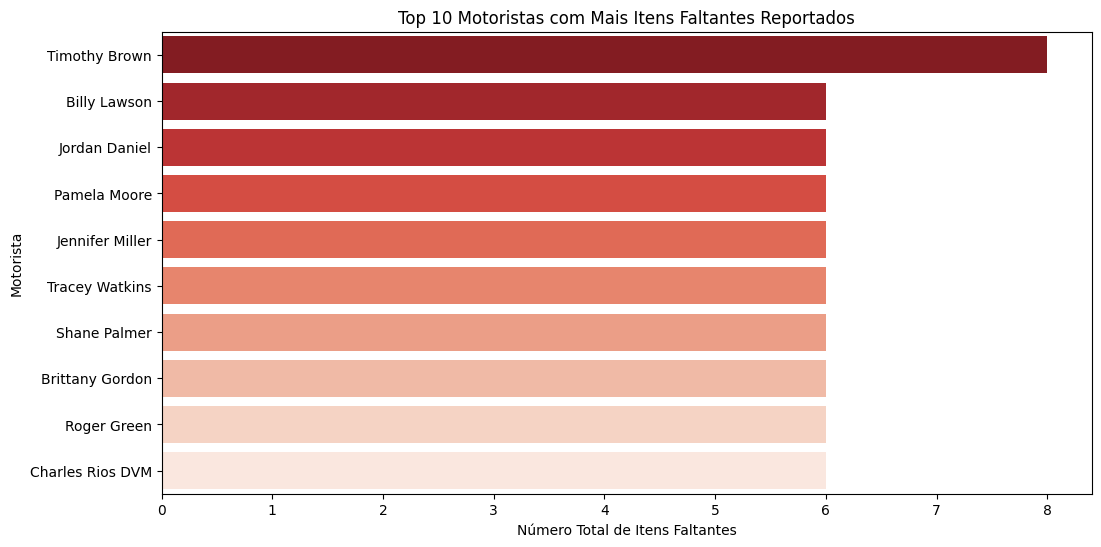

In [10]:
# Contar motoristas com maior número total de reclamações
driver_reincidence = df_final.groupby('driver_name')['items_missing'].sum().sort_values(ascending=False)

# Selecionar os 10 motoristas com maior número de reclamações
top_reincidence_drivers = driver_reincidence.head(10)

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=top_reincidence_drivers.values, y=top_reincidence_drivers.index, hue=top_reincidence_drivers.index, palette="Reds_r")

# Adicionar títulos e rótulos
plt.xlabel("Número Total de Itens Faltantes")
plt.ylabel("Motorista")
plt.title("Top 10 Motoristas com Mais Itens Faltantes Reportados")
plt.xticks(rotation=0)

# Mostrar o gráfico
plt.show()

* Gráfico identifica os motoristas (top10) que frequentemente entregam pedidos com itens faltantes, o que pode ajudar a abordar e reduzir o problema de entregas incompletas.

#### Calcular o Numero Total de Entregas, Itens Perdidos e Porcentagem por Motoristas

In [1]:
# Calcular o número total de entregas, itens perdidos e porcentagem por motorista
driver_analysis = df_final.groupby('driver_name').agg(
    age=('age', 'first'),
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a porcentagem de itens perdidos
driver_analysis['missing_percentage'] = (driver_analysis['total_missing'] / driver_analysis['total_deliveries']) * 100

# Ordenar os motoristas pela porcentagem de itens perdidos
driver_analysis = driver_analysis.sort_values(by='missing_percentage', ascending=False)

# Selecionar os 10 motoristas com maior porcentagem de itens perdidos
top_drivers = driver_analysis.head(20)
top_drivers

NameError: name 'df_final' is not defined

* A tabela resultante mostra os motoristas com as maiores taxas de itens faltantes, indicando possíveis áreas de preocupação para investigação adicional.

#### Distribuição para Idade dos Motoristas com base nos Itens Perdidos
* Entender a relação entre a idade dos motoristas e a quantidade de itens perdidos

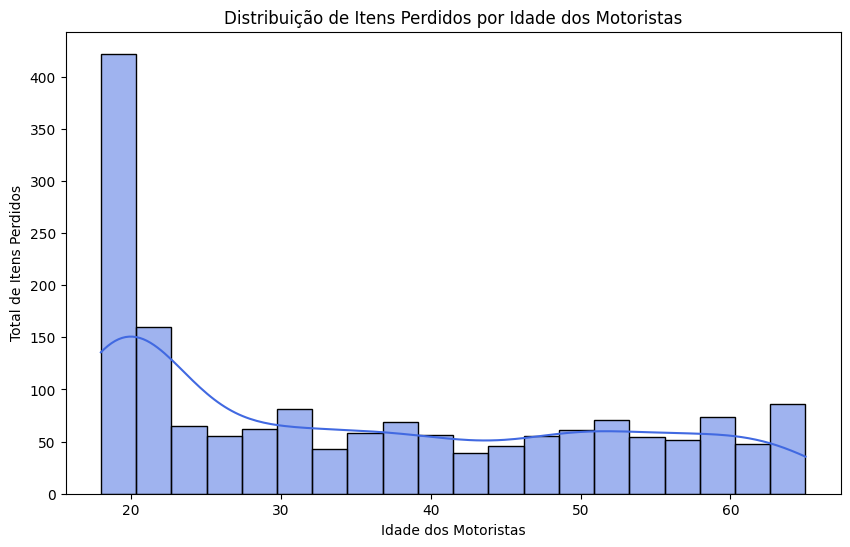

In [12]:
# Criar o histograma para idade dos motoristas com base nos itens perdidos
plt.figure(figsize=(10, 6))
sns.histplot(df_final, x='age', weights='items_missing', bins=20, kde=True, color='royalblue')
plt.title("Distribuição de Itens Perdidos por Idade dos Motoristas")
plt.xlabel("Idade dos Motoristas")
plt.ylabel("Total de Itens Perdidos")
plt.show()

* O gráfico indica que motoristas com cerca de 20 anos têm uma quantidade significativa de itens perdidos, destacando uma possível área de preocupação.

#### Taxa Média de Itens Perdidos por Grupo Etário
* Calcular a taxa média de itens perdidos para diferentes grupos etários de motoristas.
* Indicar se há algum grupo etário que apresenta uma taxa maior de itens perdidos.

driver_age_group
56-65    0.184922
26-35    0.182482
46-55    0.177374
36-45    0.169479
18-25    0.148701
Name: items_missing, dtype: float64


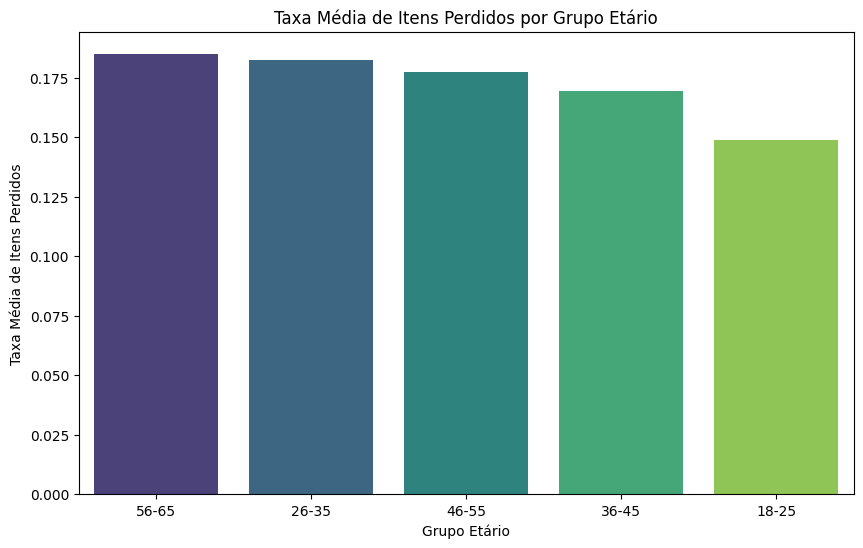

In [13]:
# Calcular a taxa média de itens perdidos por grupo etário
driver_age_group_avg_missing = df_final.groupby('driver_age_group')['items_missing'].mean().sort_values(ascending=False)

# Visualizar os resultados
print(driver_age_group_avg_missing)


# Criar o gráfico de barras para taxa média de itens perdidos por grupo etário
plt.figure(figsize=(10, 6))
sns.barplot(x=driver_age_group_avg_missing.index, y=driver_age_group_avg_missing.values, hue=driver_age_group_avg_missing.index, palette="viridis")
plt.title("Taxa Média de Itens Perdidos por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Taxa Média de Itens Perdidos")
plt.show()


* Grupo etário 56-65 anos apresenta a maior taxa média de itens perdidos
* O grupo etário 18-25 anos apresenta a menor taxa média de itens perdidos

Em termos de números totais, o grupo etário 18-25 anos é o grupo mais representado entre os motoristas.

Isso sugere que, embora o grupo etário 56-65 anos tenha uma maior taxa média de itens perdidos, o impacto em números absolutos pode ser maior no grupo de motoristas mais jovens (18-25 anos) devido à sua maior representatividade.

#### Total de Entregas e Itens Perdidos por Motoristas
* Mostrar total de entregas e o número de itens perdidos para os motoristas com maior taxa de itens faltantes.

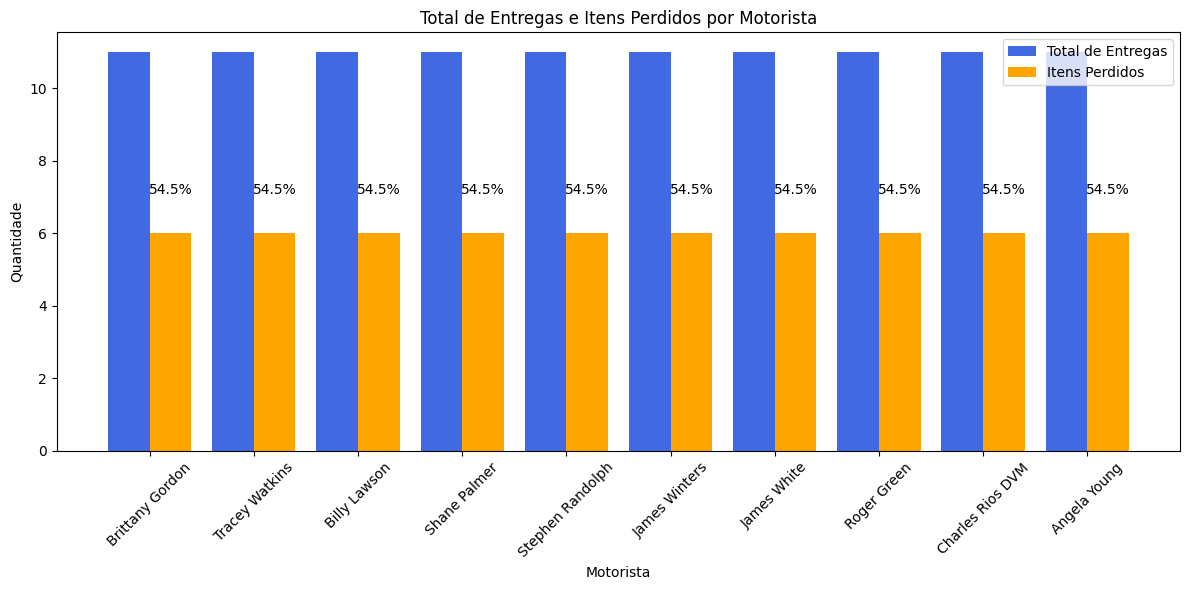

In [14]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar as barras separadas para total_deliveries e total_missing
x = range(len(top_drivers))  # Índices para os motoristas
plt.bar(x, top_drivers['total_deliveries'], color='royalblue', width=0.4, label='Total de Entregas')
plt.bar([i + 0.4 for i in x], top_drivers['total_missing'], color='orange', width=0.4, label='Itens Perdidos')

# Adicionar os números da porcentagem acima das barras de itens perdidos
for i, percentage in enumerate(top_drivers['missing_percentage']):
    plt.text(i + 0.4, top_drivers['total_missing'].iloc[i] + 1, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=10)

# Personalizar o gráfico
plt.title("Total de Entregas e Itens Perdidos por Motorista")
plt.xlabel("Motorista")
plt.ylabel("Quantidade")
plt.xticks([i + 0.2 for i in x], top_drivers.index, rotation=45)  # Ajustar os rótulos para ficarem centralizados
plt.legend(loc='upper right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


* Os 10 motoristas listados possuem o mesmo número de entregas e itens perdidos, resultando na mesma porcentagem de itens perdidos (54.5%).

Isso significa que para esses motoristas:

* **Total de Entregas:** O número total de entregas realizadas por cada motorista.
* **Itens Perdidos:** O número de itens relatados como perdidos nas entregas realizadas por esses motoristas.
* **Porcentagem de Itens Perdidos:** A porcentagem de itens perdidos em relação ao total de entregas, que é a mesma para todos os motoristas listados (54.5%).


Isso pode indicar que há um padrão consistente entre esses motoristas em relação à quantidade de itens que são perdidos durante as entregas. Isso pode ser um indicativo de um problema sistemático ou comportamento suspeito que merece uma investigação mais aprofundada.

### Identificar Clientes com Comportamento Suspeito
* Analise de clientes que frequentemente reportam itens faltantes.

In [15]:
# Taxa de reclamação por cliente
customer_complaints = df_final.groupby('customer_name').agg(
    average_missing=('items_missing', 'mean'),
    age=('customer_age', 'first'),
    age_group=('customer_age_group', 'first')  # age_group_x vem do dataset customer_data
).sort_values(by='average_missing', ascending=False)

# Visualizar os 10 clientes com maior taxa de reclamação
top_customers = customer_complaints.head(10)
print(top_customers)


                 average_missing  age age_group
customer_name                                  
Cory Spencer            1.000000   81     76-85
Crystal Smith           1.000000   44     36-45
Joshua Thompson         1.000000   79     76-85
David Mccoy             0.857143   59     56-65
Mark Mcmahon            0.800000   78     76-85
Justin Williams         0.750000   78     76-85
James Vargas            0.750000   78     76-85
Robert Odonnell         0.714286   45     36-45
Julie Reese             0.714286   80     76-85
Ruben Stevenson         0.666667   24     18-25


* Clientes com maior taxa de reclamação pertencem a várias faixas etárias.


#### Visualizar Maiores Taxas de Reclamação
* Mostra a taxa média de itens faltantes reportados pelos clientes.

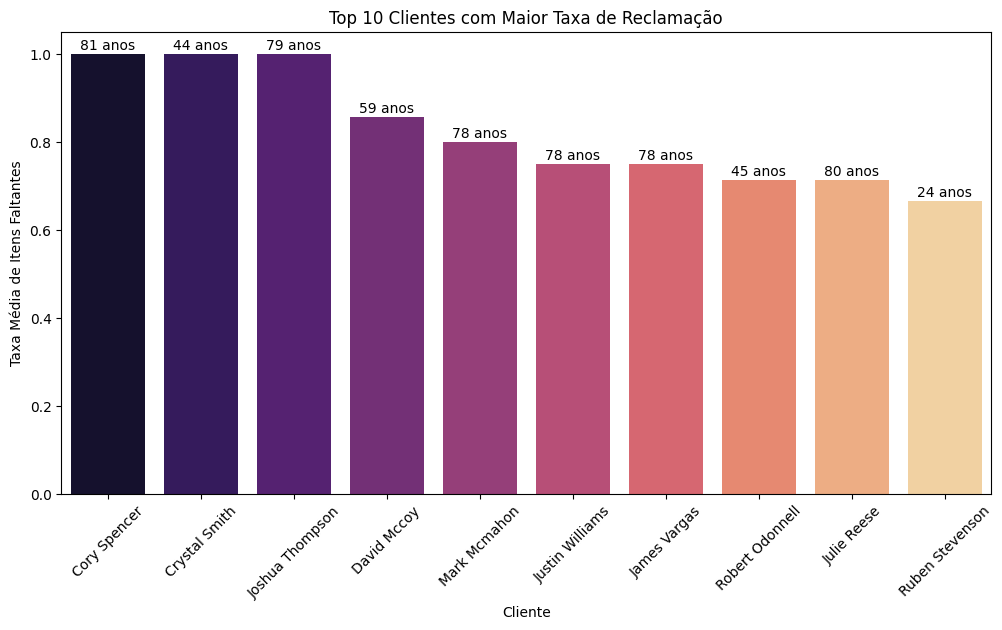

In [16]:
# Criar o gráfico de barras com as idades dos clientes como rótulos
plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.index, y=top_customers['average_missing'], hue=top_customers.index, palette="magma")
plt.title("Top 10 Clientes com Maior Taxa de Reclamação")
plt.xlabel("Cliente")
plt.ylabel("Taxa Média de Itens Faltantes")
plt.xticks(rotation=45)

# Adicionar as idades como rótulos no topo das barras
for i, (name, row) in enumerate(top_customers.iterrows()):
    plt.text(i, row['average_missing'] + 0.01, f"{row['age']} anos", ha='center', fontsize=10)

plt.show()

Monitorar esses clientes e investigar as circunstâncias das reclamações pode ajudar a identificar possíveis fraudes, problemas de entrega ou a necessidade de melhor comunicação e atendimento ao cliente.

#### Clientes com Maior Porcentagem de Itens Perdidos
* Calcular o número total de pedidos, itens perdidos e a porcentagem de itens perdidos para cada cliente.

In [17]:
# Agrupar os dados por cliente
customer_analysis = df_final.groupby('customer_name').agg(
    total_orders=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a porcentagem de itens perdidos
customer_analysis['missing_percentage'] = (customer_analysis['total_missing'] / customer_analysis['total_orders']) * 100

# Ordenar os clientes pela porcentagem de itens perdidos
customer_analysis = customer_analysis.sort_values(by='missing_percentage', ascending=False)

# Visualizar os 10 principais clientes com maior porcentagem de itens perdidos
top_customers = customer_analysis.head(10)
print(top_customers)


                 total_orders  total_missing  missing_percentage
customer_name                                                   
Cory Spencer                5              5          100.000000
Crystal Smith               4              4          100.000000
Joshua Thompson             3              3          100.000000
David Mccoy                 7              6           85.714286
Mark Mcmahon                5              4           80.000000
Justin Williams             4              3           75.000000
James Vargas                4              3           75.000000
Robert Odonnell             7              5           71.428571
Julie Reese                 7              5           71.428571
Ruben Stevenson             3              2           66.666667


* Esses resultados destacam os clientes que precisam ser monitorados de perto e investigados para entender melhor as causas dos itens faltantes, identificar possíveis fraudes ou problemas sistemáticos nas entregas.

#### Total de Pedidos e Itens Perdidos por Cliente
* Mostrar o total de pedidos e itens perdidos para os clientes com a maior porcentagem de itens faltantes.

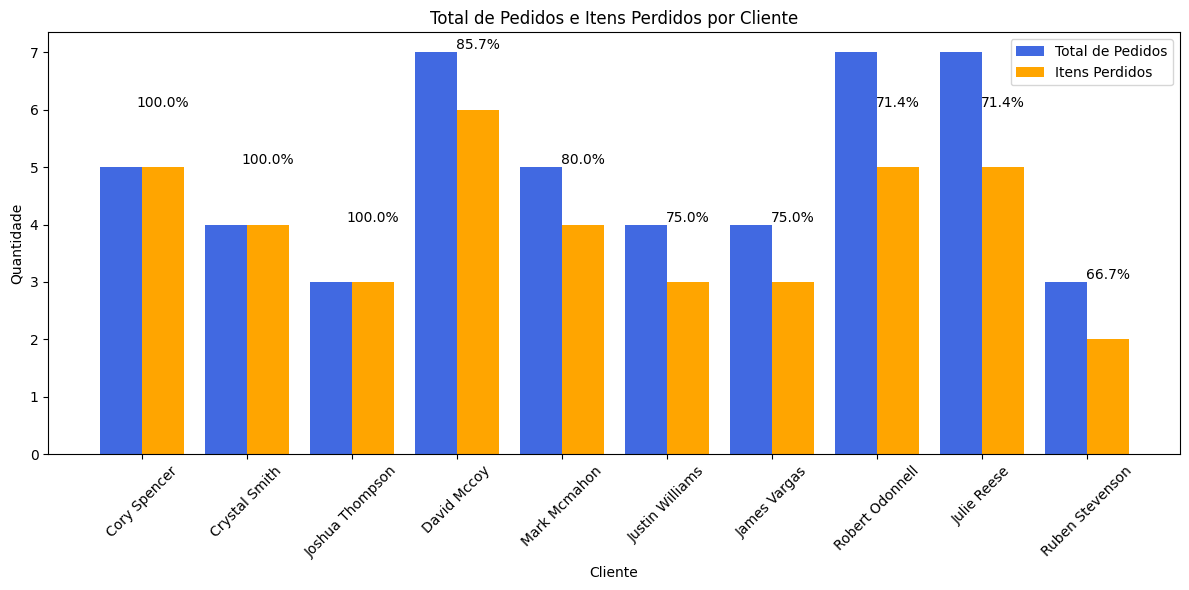

In [18]:
# Configurar o tamanho da figura
plt.figure(figsize=(12, 6))

# Criar as barras separadas para total_orders e total_missing
x = range(len(top_customers))  # Índices para os clientes
plt.bar(x, top_customers['total_orders'], color='royalblue', width=0.4, label='Total de Pedidos')
plt.bar([i + 0.4 for i in x], top_customers['total_missing'], color='orange', width=0.4, label='Itens Perdidos')

# Adicionar os números da porcentagem acima das barras de itens perdidos
for i, percentage in enumerate(top_customers['missing_percentage']):
    plt.text(i + 0.4, top_customers['total_missing'].iloc[i] + 1, f"{percentage:.1f}%", ha='center', va='bottom', fontsize=10)

# Personalizar o gráfico
plt.title("Total de Pedidos e Itens Perdidos por Cliente")
plt.xlabel("Cliente")
plt.ylabel("Quantidade")
plt.xticks([i + 0.2 for i in x], top_customers.index, rotation=45)  # Ajustar os rótulos para ficarem centralizados
plt.legend(loc='upper right')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


* Clientes como Cory Spencer, Crystal Smith e Joshua Thompson relatam 100% dos itens como perdidos. Isso pode indicar um comportamento repetitivo e anômalo que merece uma atenção especial.
* Revisões detalhadas dos processos de entrega pode ajudar a identificar pontos críticos onde os itens estão sendo perdidos. Isso inclui desde a embalagem e transporte até a entrega final ao cliente.
* Melhorar a comunicação com os clientes pode reduzir a incidência de itens faltantes. Informações claras sobre o status da entrega e verificação com os clientes no momento da entrega podem diminuir as reclamações.
* Oferecer treinamento adicional aos motoristas para garantir que os procedimentos de entrega sejam seguidos corretamente pode ajudar a minimizar itens faltantes.

#### Taxa Média de Itens Perdidos por Grupo Etário
* Calcular a taxa média de itens perdidos para diferentes grupos etários de clientes

customer_age_group
36-45    0.175709
76-85    0.174558
85+      0.169643
26-35    0.168135
56-65    0.167669
18-25    0.163470
66-75    0.162690
46-55    0.145414
Name: items_missing, dtype: float64


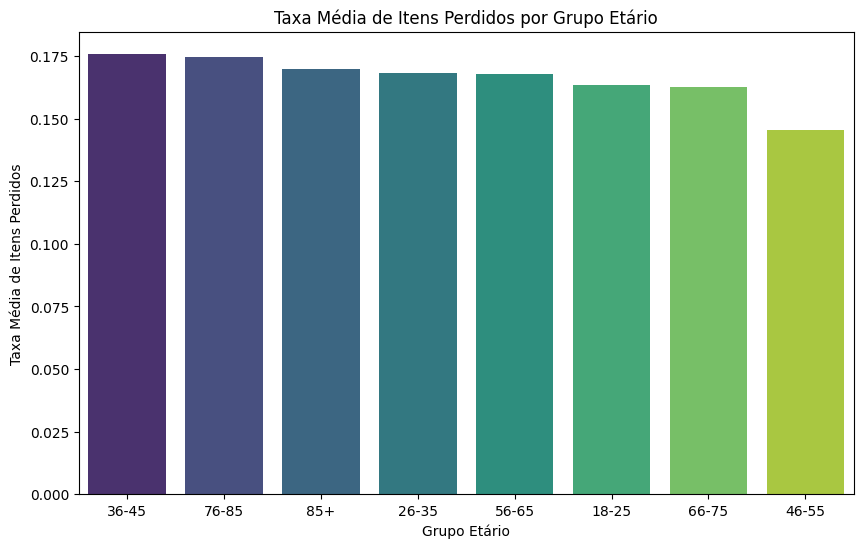

In [19]:
# Calcular a taxa média de itens perdidos por grupo etário
age_group_avg_missing = df_final.groupby('customer_age_group')['items_missing'].mean().sort_values(ascending=False)

# Visualizar os resultados
print(age_group_avg_missing)


# Criar o gráfico de barras para taxa média de itens perdidos por grupo etário
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_avg_missing.index, y=age_group_avg_missing.values, hue=age_group_avg_missing.index, palette="viridis")
plt.title("Taxa Média de Itens Perdidos por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Taxa Média de Itens Perdidos")
plt.show()


* Grupos com as maiores taxsa média de itens perdidos, podem sugerir que os clientes dessa faixa etária estão enfrentando mais problemas com suas entregas. Investigação adicional pode ajudar a entender se há fatores específicos contribuindo para essa alta taxa.
* Os clientes mais velhos também apresentam altas taxas de itens perdidos. Isso pode ser devido a uma série de fatores, como dificuldades de comunicação ou expectativas diferentes em relação às entregas. Medidas direcionadas para melhorar a experiência desses clientes podem ser benéficas.


#### Distribuição para Idade dos Cliente com Base no Itens Perdidos
* Gráfico para entender melhor a relação entre a idade dos clientes e a quantidade de itens perdidos

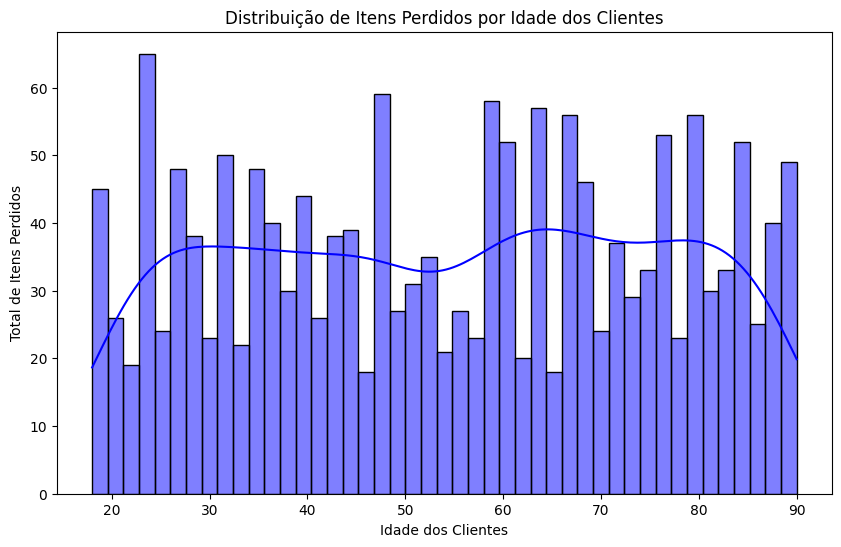

In [20]:
# Criar o histograma para idade dos clientes com base nos itens perdidos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='customer_age', weights='items_missing', bins=45, kde=True, color='blue')
plt.title("Distribuição de Itens Perdidos por Idade dos Clientes")
plt.xlabel("Idade dos Clientes")
plt.ylabel("Total de Itens Perdidos")
plt.show()


* Não há uma relação clara ou consistente entre a idade dos clientes e a quantidade de itens perdidos. A distribuição dos itens perdidos não mostra um padrão evidente que correlacione diretamente a idade dos clientes com o total de itens faltantes.

### Analisar Categorias mais Reportadas como Faltantes
* Identificar frequencia de itens faltantes por categoria

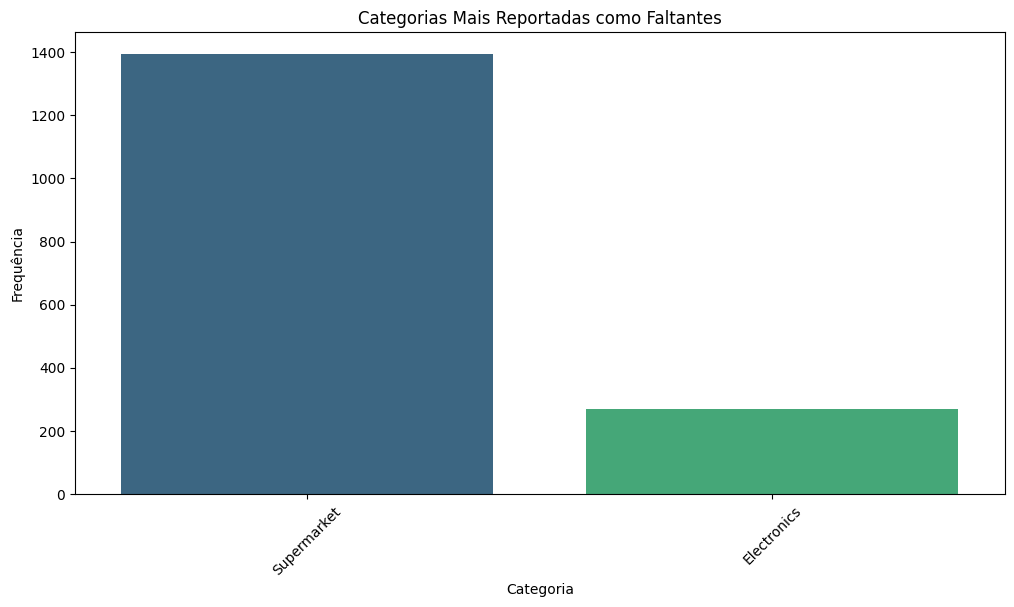

In [21]:
# Contar categorias mais reportadas como faltantes
all_categories = [item for sublist in df_final['category'].dropna() for item in sublist]
category_counts = Counter(all_categories)

# Transformar o resultado em DataFrames para visualização
category_df = pd.DataFrame(category_counts.most_common(10), columns=['Categoria', 'Frequência'])

# Criar o gráfico de barras para categorias
plt.figure(figsize=(12, 6))
sns.barplot(x='Categoria', y='Frequência', data=category_df, hue='Categoria', palette="viridis")
plt.title("Categorias Mais Reportadas como Faltantes")
plt.xlabel("Categoria")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()

A categoria `Supermarket` tem a maior frequência de itens faltantes, o que pode indicar a necessidade de revisar os processos de inventário, transporte e entrega para esta categoria. Possíveis falhas no armazenamento, manipulação ou transporte desses produtos devem ser investigadas para identificar e corrigir as causas dos itens faltantes.

### Analisar Produtos Mais Reportados como Faltantes
* Identificar produtos que aparecem frequentemente em pedidos com problemas.

In [22]:
# Criar um dicionário para mapear product_id -> product_name
product_id_to_name = dict(zip(products['product_id'], products['product_name']))

# Substituir NaN por listas vazias e garantir que todos os valores são listas
df_final['products_missing'] = df_final['products_missing'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_final['products_missing'] = df_final['products_missing'].apply(lambda x: x if isinstance(x, list) else [])

# Substituir os IDs pelos nomes dos produtos
df_final['products_missing'] = df_final['products_missing'].apply(lambda product_list: [product_id_to_name.get(pid, "Desconhecido") for pid in product_list])

# Criar uma lista com todos os produtos faltantes
all_missing_products = [product for product_list in df_final['products_missing'] for product in product_list]

# Contar a frequência de cada produto
product_counts = Counter(all_missing_products)

# Criar um DataFrame para visualização
product_df = pd.DataFrame(product_counts.items(), columns=['Product', 'Frequency']).sort_values(by='Frequency', ascending=False)

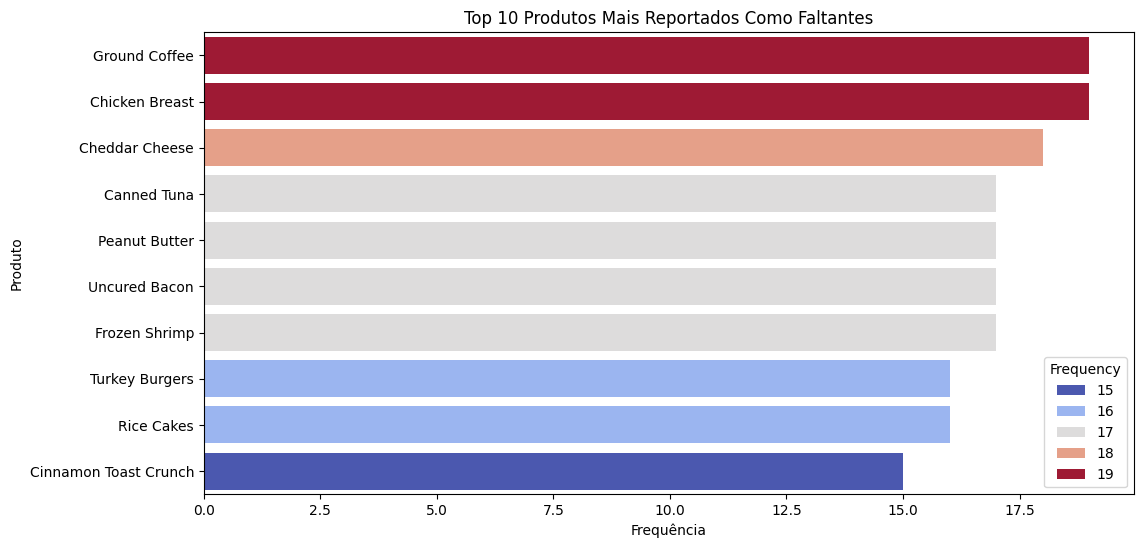

In [23]:
# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=product_df['Frequency'][:10], y=product_df['Product'][:10], hue=product_df['Frequency'][:10], palette="coolwarm")
plt.xlabel('Frequência')
plt.ylabel('Produto')
plt.title('Top 10 Produtos Mais Reportados Como Faltantes')

plt.show()

* Produtos estão no topo da lista e merecem atenção especial. Pode ser necessário revisar os processos de embalagem, armazenamento e entrega desses itens para reduzir a ocorrência de itens faltantes.

#### Analisar Padrões de Co-Ocorrência de Produtos Faltantes
* Identificar as combinações de produtos que frequentemente aparecem juntos em pedidos com problemas, destacando os pares de itens mais reportados como faltantes.

In [24]:
# Verificar as primeiras combinações de produtos faltantes
product_combinations = []

for products in df_final['products_missing']:
    product_combinations.extend(combinations(sorted(set(products)), 2))

# Contar a frequência de cada par de produtos
co_occurrence_counts = Counter(product_combinations)

# Criar um DataFrame com os resultados
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=['Product Pair', 'Frequency'])

# Ordenar os pares mais frequentes
co_occurrence_df = co_occurrence_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Exibir os 10 pares mais comuns de produtos faltantes
print(co_occurrence_df.head(10))

                                 Product Pair  Frequency
0                         (Chia Seeds, Ramen)          1
1            (Bagged Spinach, Frozen Waffles)          1
2                (Apple iPad Air, Red Grapes)          1
3                 (Hot Dog Buns, Maple Syrup)          1
4          (Shredded Carrots, Sweet Potatoes)          1
5                   (Pancake Mix, Rice Cakes)          1
6  (Beats Studio Pro Headphone, Oyster Sauce)          1
7         (Frozen Shrimp, Sony PlayStation 5)          1
8               (Protein Bars, Whipped Cream)          1
9                 (Pumpkin Puree, Red Onions)          1


* Cada par de produtos identificado apareceu apenas uma vez, indicando que não há um padrão consistente de combinações específicas de produtos que levam a problemas recorrentes.
* Embora a frequência única não indique um padrão forte, vale a pena monitorar essas combinações ao longo do tempo para ver se certos produtos frequentemente aparecem juntos em pedidos com problemas

### Analise Regional e Horarios Criticos
* Explorar padrões regionais e horários associados a entregas problemáticas

#### Categorizar Periodo de entrega

In [25]:
# Converter delivery_hour para datetime
df_final['delivery_hour'] = pd.to_datetime(df_final['delivery_hour'], format='%H:%M:%S').dt.time

# Função para categorizar os horários
def categorize_delivery_period(hour):
    if hour >= pd.to_datetime('06:00:00', format='%H:%M:%S').time() and hour < pd.to_datetime('12:00:00', format='%H:%M:%S').time():
        return 'Manhã'
    elif hour >= pd.to_datetime('12:00:00', format='%H:%M:%S').time() and hour < pd.to_datetime('18:00:00', format='%H:%M:%S').time():
        return 'Tarde'
    else:
        return 'Noite'

# Aplicar a função para criar a nova coluna
df_final['delivery_period'] = df_final['delivery_hour'].apply(categorize_delivery_period)

# Visualizar as primeiras linhas
df_final[['delivery_hour', 'delivery_period']].head()


,delivery_hour,delivery_period
0,08:37:28,Manhã
1,09:31:17,Manhã
2,10:43:49,Manhã
3,09:48:33,Manhã
4,10:09:49,Manhã


* A tabela gerada após a execução do código apresenta duas colunas: delivery_hour e delivery_period, com os horários das entregas e os períodos categorizados como "Manhã" (a partir 06:00), "Tarde" (apartir 12:00) e "Noite" (a partir 18:00).

#### Análise Periodos Criticos
* Calcular o número total de entregas e a soma dos itens faltantes para cada periodo do dia

In [26]:
# Contar o número total de entregas e calcular a soma dos itens faltantes por período
period_summary = df_final.groupby('delivery_period').agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)

# Calcular a taxa média de reclamações por entrega
period_summary['average_missing_rate'] = period_summary['total_missing'] / period_summary['total_deliveries']

# Ordenar os resultados pelo número total de entregas
period_summary = period_summary.sort_values(by='total_deliveries', ascending=False)

# Visualizar os resultados
period_summary


,total_deliveries,total_missing,average_missing_rate
delivery_period,,,
Noite,4993,813,0.162828
Tarde,2526,404,0.159937
Manhã,2481,440,0.177348


#### Visualizaçao dos Dados por Periodo

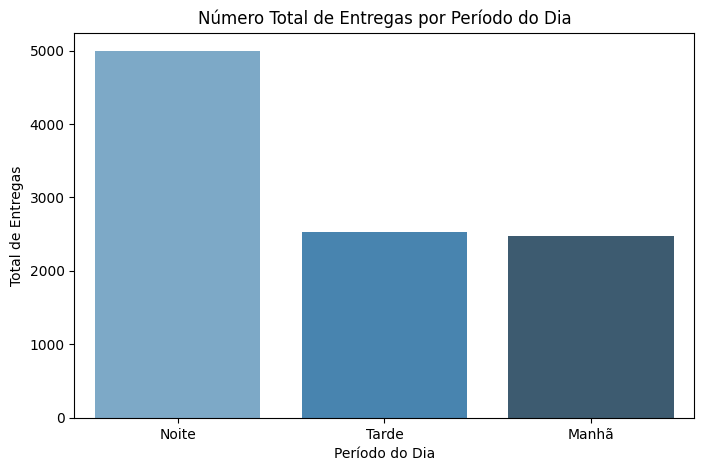

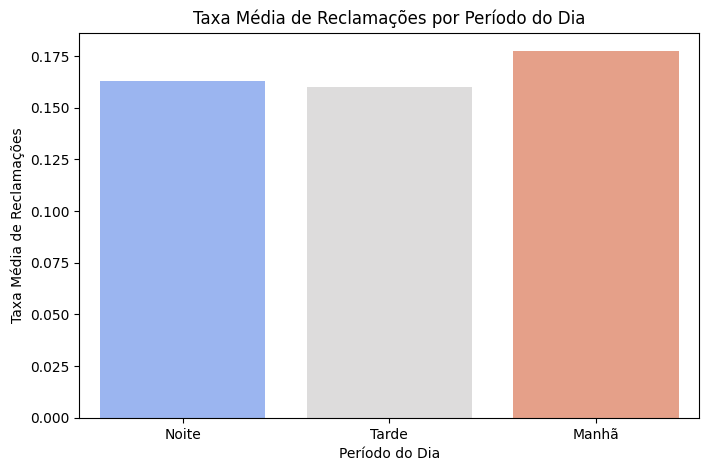

In [27]:
# Gráfico 1: Número total de entregas por período
plt.figure(figsize=(8, 5))
sns.barplot(x=period_summary.index, y=period_summary['total_deliveries'], hue=period_summary.index,  palette="Blues_d")
plt.title("Número Total de Entregas por Período do Dia")
plt.xlabel("Período do Dia")
plt.ylabel("Total de Entregas")
plt.show()

# Gráfico 2: Taxa média de reclamações por entrega
plt.figure(figsize=(8, 5))
sns.barplot(x=period_summary.index, y=period_summary['average_missing_rate'], hue=period_summary.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Período do Dia")
plt.xlabel("Período do Dia")
plt.ylabel("Taxa Média de Reclamações")
plt.show()


* Os dados sugerem que o período da Manhã tem a maior taxa média de reclamações por entrega, apesar de ter o menor número total de entregas. Isso pode indicar que há desafios logísticos ou operacionais específicos durante este período que precisam ser abordados.

#### Resumo por Região e Período do Dia
* Explorar padrões regionais e horários associados a entregas problemáticas
* Agrupar os dados por região e período de entrega.

In [28]:
region_period_summary = df_final.groupby(['region', 'delivery_period']).agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)
region_period_summary['average_missing_rate'] = region_period_summary['total_missing'] / region_period_summary['total_deliveries']
region_period_summary = region_period_summary.reset_index()

region_period_summary.head()

,region,delivery_period,total_deliveries,total_missing,average_missing_rate
0,Altamonte Springs,Manhã,358,65,0.181564
1,Altamonte Springs,Noite,718,124,0.172702
2,Altamonte Springs,Tarde,350,64,0.182857
3,Apopka,Manhã,347,62,0.178674
4,Apopka,Noite,723,137,0.189488


#### Visualizar Resumo por Região e Periodo do Dia

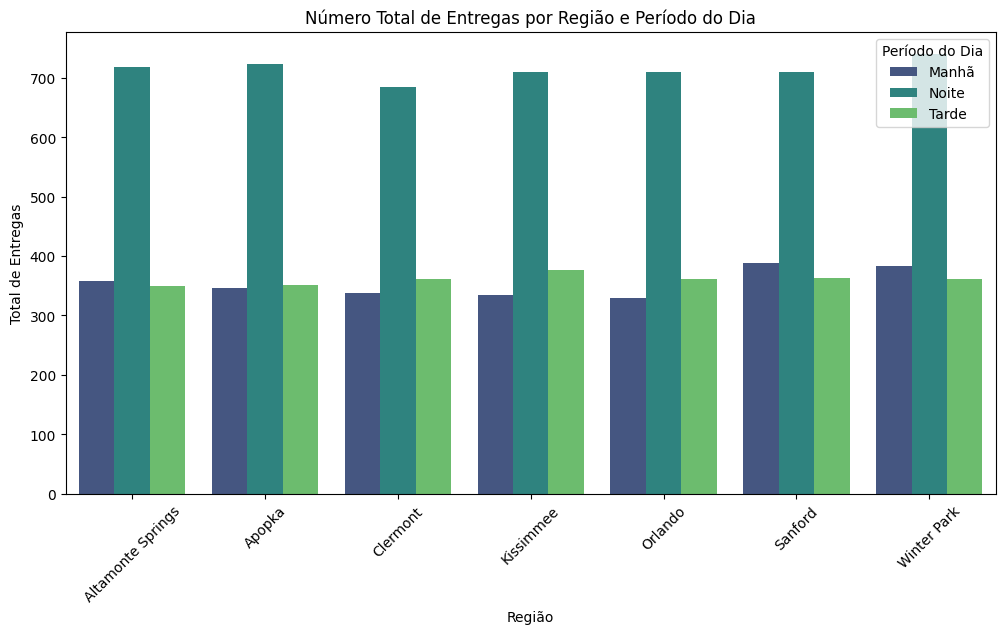

In [29]:
# Criar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=region_period_summary,
    x='region',
    y='total_deliveries',
    hue='delivery_period',
    palette="viridis"
)
plt.title("Número Total de Entregas por Região e Período do Dia")
plt.xlabel("Região")
plt.ylabel("Total de Entregas")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()

* Os dados não indicam uma relação clara ou significativa entre a região e a ocorrência de itens faltantes.

#### Taxa Média de Reclamaçoes por Regiao e Período do Dia

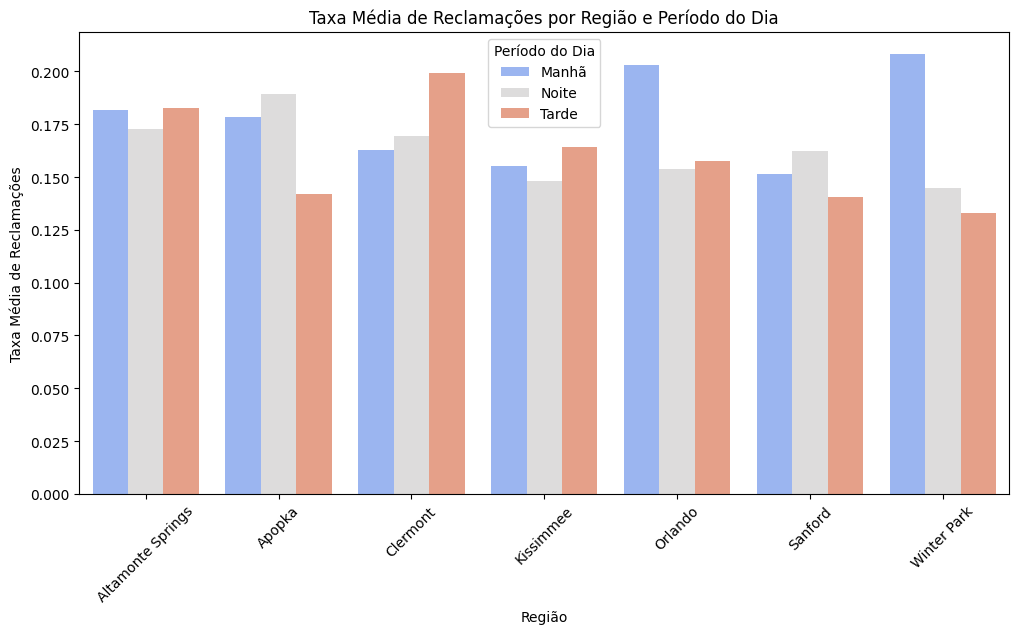

In [30]:
# Criar o gráfico de barras empilhadas para a taxa média de reclamações
plt.figure(figsize=(12, 6))
sns.barplot(
    data=region_period_summary,
    x='region',
    y='average_missing_rate',
    hue='delivery_period',
    palette="coolwarm"
)
plt.title("Taxa Média de Reclamações por Região e Período do Dia")
plt.xlabel("Região")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


* As taxas de itens faltantes variam mais de acordo com os períodos em algumas regiões específicas.

### Análise de Desempenho dos Motoristas por Período do Dia
* Agrupar os dados por motoristas e periodo do dia para analisar o desempenho dos motoristas em termos de entregas e itens faltantes.

In [31]:
# Agrupar dados por motorista e período do dia
driver_period_summary = df_final.groupby(['driver_name', 'delivery_period']).agg(
    total_deliveries=('order_id', 'count'),
    total_missing=('items_missing', 'sum')
)
driver_period_summary['average_missing_rate'] = driver_period_summary['total_missing'] / driver_period_summary['total_deliveries']
driver_period_summary = driver_period_summary.reset_index()

# Ordenar os resultados pelos motoristas com as maiores taxas de itens faltantes
top_10_drivers = driver_period_summary.sort_values(by='average_missing_rate', ascending=False).head(10)

# Visualizar os resultados
top_10_drivers

,driver_name,delivery_period,total_deliveries,total_missing,average_missing_rate
568,Charles Barrett,Manhã,1,2,2.000000
504,Candace Taylor,Manhã,1,2,2.000000
2312,Michael Martin,Manhã,1,2,2.000000
1504,Jennifer Rasmussen,Tarde,1,2,2.000000
2951,Shane Palmer,Manhã,3,5,1.666667
1269,Jacob Barker,Manhã,2,3,1.500000
3080,Stephen Randolph,Manhã,2,3,1.500000
2461,Mrs. Valerie Schwartz MD,Tarde,2,3,1.500000
3224,Toni Carter DDS,Tarde,2,3,1.500000
1982,Kimberly Townsend,Manhã,2,3,1.500000


Esses resultados indicam que há motoristas específicos com altos índices de itens faltantes durante certos períodos do dia. As seguintes ações podem ser recomendadas:

* **Treinamento Adicional:** Oferecer treinamento adicional para motoristas com altas taxas de itens faltantes para garantir que os procedimentos de entrega sejam seguidos corretamente.
* **Monitoramento:** Monitorar de perto as entregas realizadas por esses motoristas para identificar possíveis causas de itens faltantes e tomar medidas corretivas.
* **Revisão de Processos:** Revisar os processos logísticos e operacionais durante os períodos críticos (como a manhã) para identificar áreas de melhoria.

### Numero Total de Motoristas com Mais Entregas
* Visualizar número total de entregas realizadas pelos 10 motoristas com mais entregas.

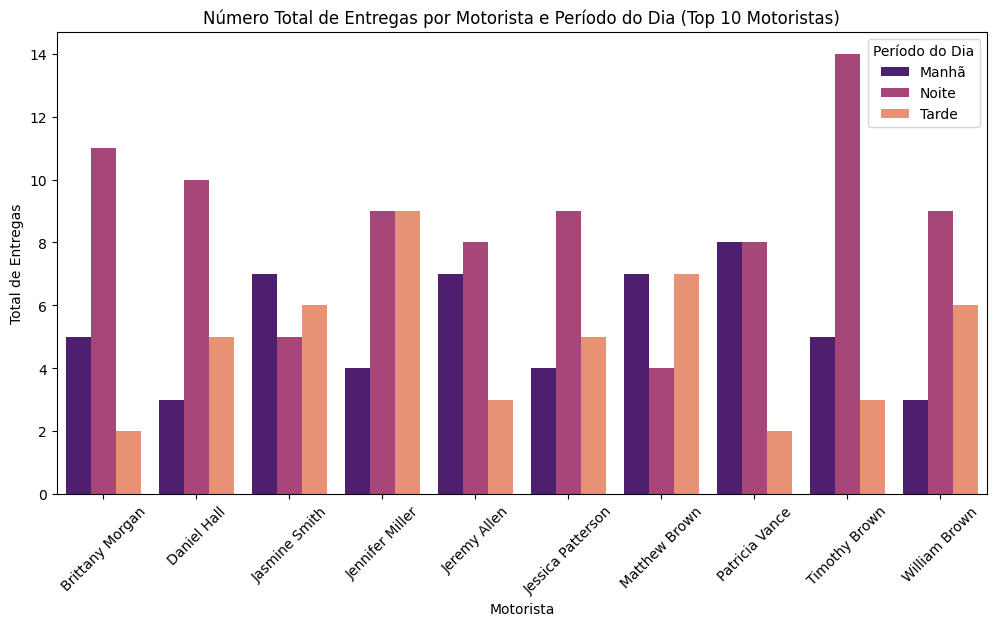

In [32]:
# Filtrar os 10 motoristas com mais entregas para visualização
top_drivers = driver_period_summary.groupby('driver_name')['total_deliveries'].sum().nlargest(10).index
filtered_driver_data = driver_period_summary[driver_period_summary['driver_name'].isin(top_drivers)]

# Criar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_driver_data,
    x='driver_name',
    y='total_deliveries',
    hue='delivery_period',
    palette="magma"
)
plt.title("Número Total de Entregas por Motorista e Período do Dia (Top 10 Motoristas)")
plt.xlabel("Motorista")
plt.ylabel("Total de Entregas")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


* O gráfico destaca os 10 motoristas que realizaram o maior número de entregas, mostrando a distribuição de suas entregas em diferentes períodos do dia: Manhã, Tarde e Noite.
* A análise do gráfico pode ajudar a identificar áreas de melhoria e otimização:

    * **Balanceamento de Tarefas:** Se um motorista tem um número excessivo de entregas em um período específico, pode ser útil redistribuir tarefas para garantir que as cargas de trabalho sejam mais equilibradas. Isso pode ajudar a melhorar a eficiência e a qualidade das entregas.

    * **Treinamento e Suporte:** Identificar motoristas que enfrentam desafios em certos períodos do dia pode permitir a implementação de treinamentos adicionais ou suporte específico. Por exemplo, motoristas que têm altas taxas de itens faltantes em certos períodos podem se beneficiar de treinamento sobre melhores práticas de entrega.

#### Taxa Média de Reclamações e Períodos do dia
* Visualizar a taxa média de reclamações (itens faltantes) dos 10 motoristas com mais entregas, categorizadas por período do dia.

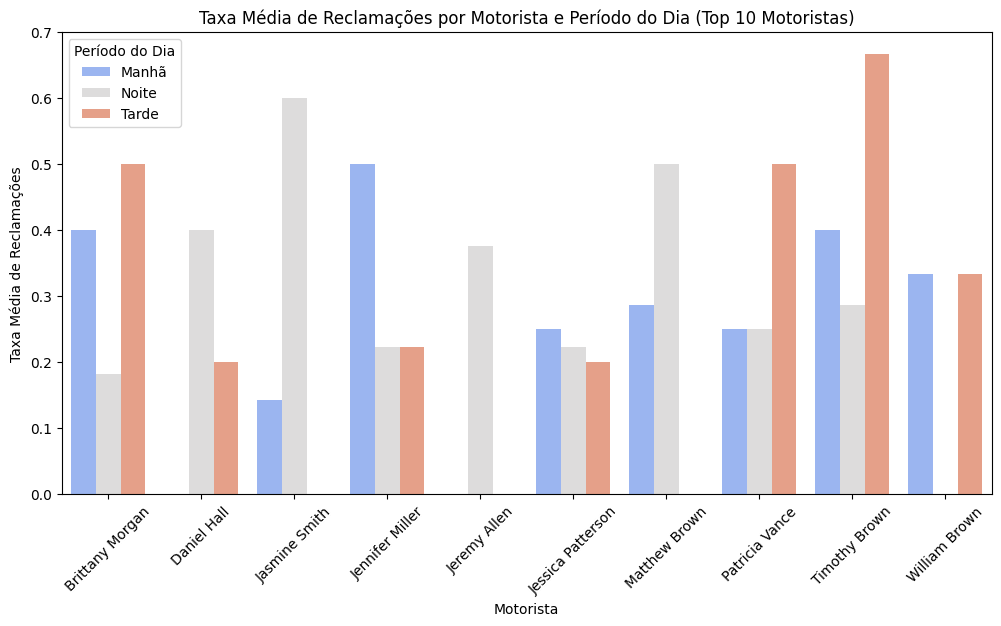

In [33]:
# Criar o gráfico de barras empilhadas para a taxa média de reclamações (Top 10 Motoristas)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_driver_data,
    x='driver_name',
    y='average_missing_rate',
    hue='delivery_period',
    palette="coolwarm"
)
plt.title("Taxa Média de Reclamações por Motorista e Período do Dia (Top 10 Motoristas)")
plt.xlabel("Motorista")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.legend(title="Período do Dia")
plt.show()


Este gráfico fornece uma visão clara das taxas de reclamação por motorista, categorizadas por períodos do dia. As informações obtidas podem ser usadas para:

* Melhorar os processos operacionais durante os períodos críticos.

* Ajustar horários e rotas de entrega para maior eficiência.

* Oferecer treinamento e suporte específicos para motoristas que enfrentam desafios em determinados períodos.

Com essas medidas, é possível otimizar o desempenho dos motoristas e reduzir a incidência de itens faltantes, resultando em um serviço de entrega mais eficiente e satisfatório.

### Análise da Taxa Média de Reclamações por Dia da Semana
* Identificar se há dias especificos com maiores incidências de itens faltantes.

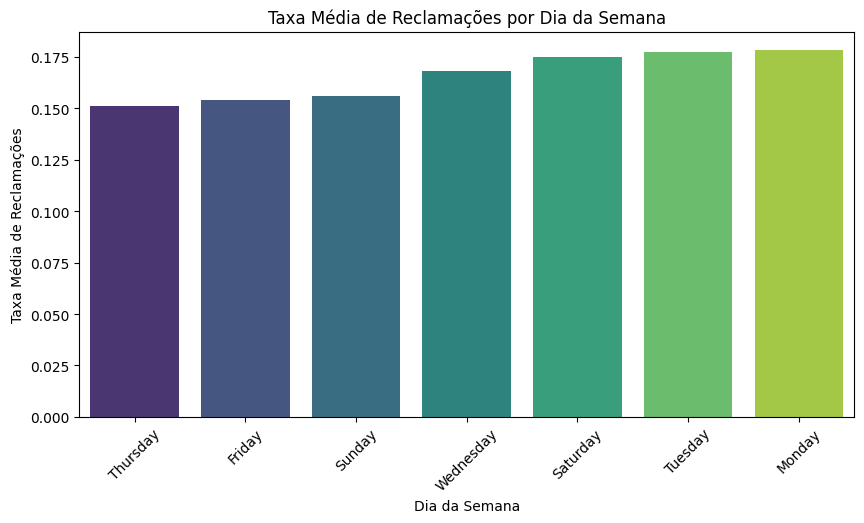

day_of_week
Thursday     0.151406
Friday       0.154167
Sunday       0.156019
Wednesday    0.168079
Saturday     0.174797
Tuesday      0.177465
Monday       0.178311
Name: items_missing, dtype: float64

In [34]:
# Taxa média de reclamações por dia da semana
df_final['day_of_week'] = pd.to_datetime(df_final['date']).dt.day_name()
day_of_week_complaints = df_final.groupby('day_of_week')['items_missing'].mean().sort_values()

# Gráfico para taxa média de reclamações por dia da semana
plt.figure(figsize=(10, 5))
sns.barplot(x=day_of_week_complaints.index, y=day_of_week_complaints.values, hue=day_of_week_complaints.index, palette="viridis")
plt.title("Taxa Média de Reclamações por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Taxa Média de Reclamações")
plt.xticks(rotation=45)
plt.show()

day_of_week_complaints

Os dados sugerem que há variações significativas na taxa média de reclamações ao longo da semana. A análise revela que o início da semana (Segunda-feira e Terça-feira) tem as maiores taxas de reclamações. Com base nisso, algumas ações podem ser recomendadas:

**Melhoria dos Processos no Início da Semana:**

* Revisar e otimizar os processos logísticos e operacionais no início da semana para reduzir as taxas de reclamações.

* Implementar estratégias específicas para gerenciar o acúmulo de pedidos do final de semana e garantir uma organização eficiente na segunda-feira.

**Monitoramento e Feedback Contínuos:**

* Monitorar continuamente as taxas de reclamações ao longo da semana para identificar quaisquer tendências emergentes e permitir a implementação de ações corretivas em tempo hábil.

* Coletar feedback dos motoristas e equipe operacional sobre os desafios enfrentados nos diferentes dias da semana e usar essas informações para melhorar os processos.

**Planejamento de Recursos:**

* Ajustar a alocação de recursos e a programação de entregas para garantir que os períodos críticos, como o início da semana, recebam atenção adequada e suporte adicional.

### Análise da Taxa Média de Reclamações por Faixa Etária
* Analisar a taxa média de reclamações por faixa etária dos motoristas e dos clientes, para identificar se há grupos etários específicos que apresentam maiores incidências de itens faltantes

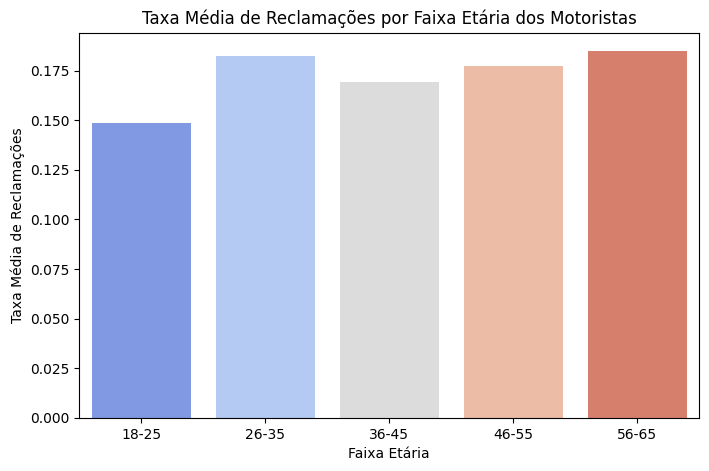

Taxa media de Reclamações por motoristas driver_age_group
18-25    0.148701
26-35    0.182482
36-45    0.169479
46-55    0.177374
56-65    0.184922
Name: items_missing, dtype: float64


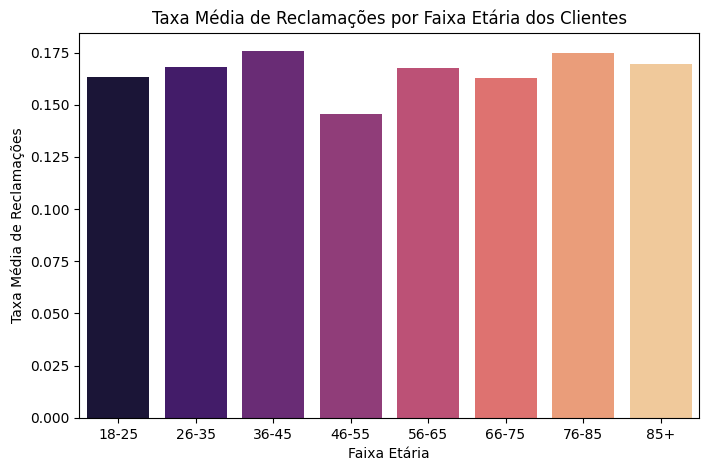

Taxa media de Reclamações por clientes customer_age_group
18-25    0.163470
26-35    0.168135
36-45    0.175709
46-55    0.145414
56-65    0.167669
66-75    0.162690
76-85    0.174558
85+      0.169643
Name: items_missing, dtype: float64


In [35]:
# Taxa média de reclamações por faixa etária dos motoristas
driver_age_complaints = df_final.groupby('driver_age_group')['items_missing'].mean()

# Taxa média de reclamações por faixa etária dos clientes
customer_age_complaints = df_final.groupby('customer_age_group')['items_missing'].mean()

# Gráfico para motoristas
plt.figure(figsize=(8, 5))
sns.barplot(x=driver_age_complaints.index, y=driver_age_complaints.values, hue=driver_age_complaints.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Faixa Etária dos Motoristas")
plt.xlabel("Faixa Etária")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

print("Taxa media de Reclamações por motoristas", driver_age_complaints)

# Gráfico para clientes
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_age_complaints.index, y=customer_age_complaints.values, hue=customer_age_complaints.index, palette="magma")
plt.title("Taxa Média de Reclamações por Faixa Etária dos Clientes")
plt.xlabel("Faixa Etária")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

print("Taxa media de Reclamações por clientes", customer_age_complaints)


* Motoristas mais jovens tendem a ter menos reclamações, enquanto motoristas mais velhos enfrentam maiores desafios. Ações como treinamento específico e suporte adicional podem ser benéficas para motoristas nas faixas etárias mais altas.
* Clientes na faixa etária de 46-55 anos têm menos reclamações, enquanto grupos de 36-45 anos e 76-85 anos enfrentam mais desafios. Foco em melhorias específicas para esses grupos pode ajudar a reduzir a incidência de itens faltantes e melhorar a satisfação do cliente.

### Análise da Taxa Média de Reclamações por Faixa de Tamanho do Pedido
* Analisar a taxa média de reclamações de itens faltantes por faixa de tamanho do pedido, para identificar se há uma relação entre o tamanho do pedido e a incidência de itens faltantes.

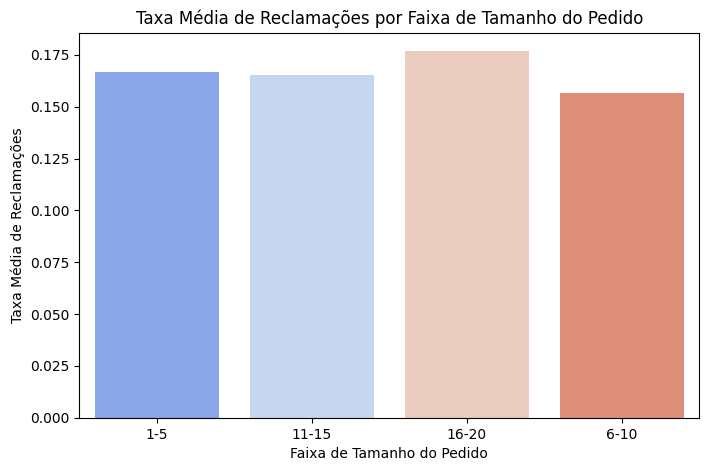

items_range
1-5      0.166667
11-15    0.165289
16-20    0.176812
6-10     0.156416
Name: items_missing, dtype: float64

In [36]:
# Taxa média de reclamações por faixa de tamanho do pedido
size_range_complaints = df_final.groupby('items_range')['items_missing'].mean()

# Gráfico para taxa média de reclamações por faixa de tamanho do pedido
plt.figure(figsize=(8, 5))
sns.barplot(x=size_range_complaints.index, y=size_range_complaints.values, hue=size_range_complaints.index, palette="coolwarm")
plt.title("Taxa Média de Reclamações por Faixa de Tamanho do Pedido")
plt.xlabel("Faixa de Tamanho do Pedido")
plt.ylabel("Taxa Média de Reclamações")
plt.show()

size_range_complaints


* A análise fornece uma visão clara da taxa média de reclamações por faixa de tamanho do pedido. Os insights obtidos podem ser usados para implementar melhorias específicas nos processos de entrega e logística, garantindo um serviço mais eficiente e satisfatório, independentemente do tamanho do pedido.

### Análise de Proporção de Pedidos com Produtos Faltantes
Análise detalhada da proporção de:
* Pedidos sem produtos faltantes
* Pedidos com 1 produto faltante
* Pedidos com 2 produtos faltantes
* Pedidos com 3 produtos faltantes

In [37]:
# Contar o total de pedidos
total_pedidos = len(df_final)

# Contar pedidos em cada categoria
vendas_normais = (df_final['products_missing'].isnull() | (df_final['products_missing'].apply(len) == 0)).sum()
vendas_1_item = (df_final['products_missing'].apply(len) == 1).sum()
vendas_2_itens = (df_final['products_missing'].apply(len) == 2).sum()
vendas_3_itens = (df_final['products_missing'].apply(len) == 3).sum()

# Calcular as proporções em porcentagem
percent_vendas_normais = (vendas_normais / total_pedidos) * 100
percent_vendas_1_item = (vendas_1_item / total_pedidos) * 100
percent_vendas_2_itens = (vendas_2_itens / total_pedidos) * 100
percent_vendas_3_itens = (vendas_3_itens / total_pedidos) * 100

# Exibir os resultados corrigidos
print(f"Pedidos sem produtos faltantes: {percent_vendas_normais:.2f}%")
print(f"Pedidos com 1 produto faltante: {percent_vendas_1_item:.2f}%")
print(f"Pedidos com 2 produtos faltantes: {percent_vendas_2_itens:.2f}%")
print(f"Pedidos com 3 produtos faltantes: {percent_vendas_3_itens:.2f}%")

Pedidos sem produtos faltantes: 84.99%
Pedidos com 1 produto faltante: 13.58%
Pedidos com 2 produtos faltantes: 1.25%
Pedidos com 3 produtos faltantes: 0.18%


### Visualizar Proporção de Pedidos com Produtos Faltantes


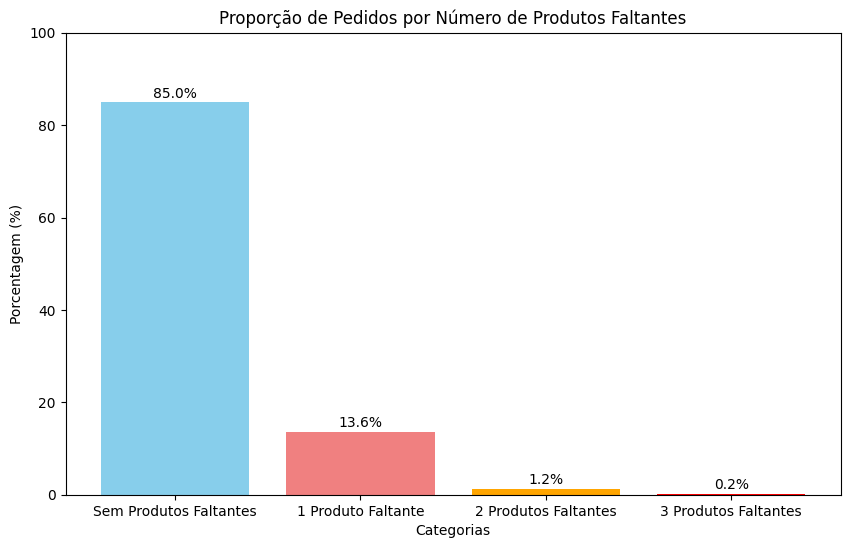

In [38]:
# Dados para o gráfico
categories = ['Sem Produtos Faltantes', '1 Produto Faltante', '2 Produtos Faltantes', '3 Produtos Faltantes']
values = [percent_vendas_normais, percent_vendas_1_item, percent_vendas_2_itens, percent_vendas_3_itens]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'lightcoral', 'orange', 'red'])
plt.title("Proporção de Pedidos por Número de Produtos Faltantes")
plt.ylabel("Porcentagem (%)")
plt.xlabel("Categorias")
plt.ylim(0, 100)  # Limitar o eixo Y para facilitar a visualização das proporções

# Adicionar rótulos nas barras
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)

plt.show()


* Esses resultados indicam que a grande maioria dos pedidos é entregue sem produtos faltantes, o que é um sinal positivo da eficiência do sistema de entrega
* Há uma proporção significativa de pedidos com 1 produto faltante (13.58%), o que sugere a necessidade de investigar e abordar possíveis causas dessa falha.
* Pedidos com 2 ou 3 produtos faltantes são muito menos comuns, mas é importante continuar monitorando esses casos para garantir que eles não aumentem no futuro.

## Manipulação de Dados de Produtos Faltantes
* Verificar e Limpar os dados
* Explodir listas em várias colunas
* Substituir valores nulos para garantir a consistencia dos dados.

### Explodir Coluna
* A coluna products_missing será transformada de listas para valores individuais em linhas separadas. Isso facilita a análise e manipulação dos dados.

In [39]:
# Explodir apenas a coluna 'products_missing'
df_price = df_final.copy()
df_price = df_price.explode('products_missing', ignore_index=True)

# Verificar as primeiras linhas
df_price.head()


,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,missing_rate,...,driver_name,age,Trips,driver_age_group,products_missing,product_name,category,price,delivery_period,day_of_week
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,08:37:28,WDID10627,WCID5031,0.100000,...,Jeremy Ramos,64,44,56-65,Apple MacBook Pro,[Apple MacBook Pro],[Electronics],424.82,Manhã,Sunday
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,09:31:17,WDID10533,WCID5794,0.090909,...,Michelle Robinson,41,45,36-45,Instant Noodles,[Instant Noodles],[Supermarket],5.80,Manhã,Sunday
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,10:43:49,WDID10559,WCID5599,0.055556,...,Thomas White,30,67,26-35,Romaine Lettuce,[Romaine Lettuce],[Supermarket],14.22,Manhã,Sunday
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,09:48:33,WDID10622,WCID5005,0.083333,...,Daniel Newman,61,34,56-65,Salted Butter,[Salted Butter],[Supermarket],9.89,Manhã,Sunday
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,10:09:49,WDID10654,WCID5114,0.333333,...,Chris Ryan,51,31,46-55,Red Onions,[Red Onions],[Supermarket],18.81,Manhã,Sunday


### Verificar Listas e Valores Nulos
* Verifica se as colunas `product_name`, `category` e `price`contem listas ou valores nulos, imprimindo as primeiras linhas

In [40]:
# Verificar se as colunas contêm listas ou valores nulos
print(df_final['product_name'].head())
print(df_final['category'].head())
print(df_final['price'].head())

0    [Apple MacBook Pro]
1      [Instant Noodles]
2      [Romaine Lettuce]
3        [Salted Butter]
4           [Red Onions]
Name: product_name, dtype: object
0    [Electronics]
1    [Supermarket]
2    [Supermarket]
3    [Supermarket]
4    [Supermarket]
Name: category, dtype: object
0    424.82
1      5.80
2     14.22
3      9.89
4     18.81
Name: price, dtype: float64


### Substituir Valores Nulos por Listas Vazias
* Substitui valores nulos nas colunas `product_name`, `category` e `price` por listas vazias para garantir a integridade dos dados.

In [41]:
# Substituir valores nulos por listas vazias
df_final['product_name'] = df_final['product_name'].apply(lambda x: x if isinstance(x, list) else [])
df_final['category'] = df_final['category'].apply(lambda x: x if isinstance(x, list) else [])
df_final['price'] = df_final['price'].apply(lambda x: x if isinstance(x, list) else [])


### Explodir Colunas Relacionadas
* As colunas `product_name`, `category` e `price` são explodidas de forma similar a `products_missing`.

In [42]:
# Explodir as outras colunas relacionadas
df_price['product_name'] = df_price['product_name'].explode(ignore_index=True)
df_price['category'] = df_price['category'].explode(ignore_index=True)
df_price['price'] = df_price['price'].explode(ignore_index=True)

# Verificar as primeiras linhas após explodir todas as colunas
df_price.head()

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,missing_rate,...,driver_name,age,Trips,driver_age_group,products_missing,product_name,category,price,delivery_period,day_of_week
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,08:37:28,WDID10627,WCID5031,0.100000,...,Jeremy Ramos,64,44,56-65,Apple MacBook Pro,Apple MacBook Pro,Electronics,424.82,Manhã,Sunday
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,09:31:17,WDID10533,WCID5794,0.090909,...,Michelle Robinson,41,45,36-45,Instant Noodles,Instant Noodles,Supermarket,5.80,Manhã,Sunday
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,10:43:49,WDID10559,WCID5599,0.055556,...,Thomas White,30,67,26-35,Romaine Lettuce,Romaine Lettuce,Supermarket,14.22,Manhã,Sunday
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,09:48:33,WDID10622,WCID5005,0.083333,...,Daniel Newman,61,34,56-65,Salted Butter,Salted Butter,Supermarket,9.89,Manhã,Sunday
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,10:09:49,WDID10654,WCID5114,0.333333,...,Chris Ryan,51,31,46-55,Red Onions,Red Onions,Supermarket,18.81,Manhã,Sunday


### Verificação de Consistência nos Dados
* Verificar as primeiras linhas do DataFrame resultante para garantir que as colunas `order_id`, `products_missing`, `product_name`, `category` e `price` estejam consistentes.

In [43]:
# Verificar consistência nos dados
df_price[['order_id', 'products_missing', 'product_name', 'category', 'price']].head(10)

,order_id,products_missing,product_name,category,price
0,c9da15aa-be24-4871-92a3-dfa7746fff69,Apple MacBook Pro,Apple MacBook Pro,Electronics,424.82
1,ccacc183-09f8-4fd5-af35-009d18656326,Instant Noodles,Instant Noodles,Supermarket,5.80
2,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,Romaine Lettuce,Romaine Lettuce,Supermarket,14.22
3,993d31f4-9358-41f0-a371-0021e55cef5d,Salted Butter,Salted Butter,Supermarket,9.89
4,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,Red Onions,Red Onions,Supermarket,18.81
5,d0b8162c-2dfc-4038-93e2-fbe240dba870,Cereal Bars,Cereal Bars,Supermarket,6.13
6,97fd47af-79b1-4177-b0be-2d26a2f8c288,Italian Sausage,Italian Sausage,Supermarket,12.71
7,7e8fb589-7a61-43c1-aacb-c30e53dc1acc,NaN,NaN,NaN,NaN
8,cf227256-5702-40f0-9e6e-a8aa231bf842,NaN,NaN,NaN,NaN
9,11b841e4-c021-41eb-9f81-dd90c15d6557,NaN,NaN,NaN,NaN


### Verificação de Valores Nulos e Estatísticas Básicas
* Calcula e imprime a quantidade de valores nulos em cada uma das colunas principais e exibe estatísticas básicas da coluna `price`, como média, desvio padrão, mínimo e máximo.

In [44]:
# Verificar se há valores nulos nas colunas principais
print(df_price[['products_missing', 'product_name', 'category', 'price']].isnull().sum())

# Verificar estatísticas básicas da coluna 'price'
print(df_price['price'].describe())


products_missing    8499
product_name        8200
category            8200
price               8499
dtype: int64
count    1662.000000
mean       97.433387
std       206.888260
min         2.160000
25%         9.480000
50%        15.280000
75%        24.400000
max       922.000000
Name: price, dtype: float64


### Análise de Pedidos Completos e Produtos Faltantes
* Calcular o valor total das vendas normais e analisar os pedidos com produtos faltantes
* Indicar perdas financeiras associadas
* Categorizar pedidos com base na quantidade de produtos faltantes
* Calcular o valor total perdido para cada categoria

In [45]:
# Filtrar pedidos sem produtos faltantes
df_normais = df_price[df_price['products_missing'].isnull()]

# Calcular o valor total de vendas normais
valor_total_normais = df_normais['order_amount'].sum()

num_pedidos_completos = len(df_normais)

# Filtrar apenas os pedidos com produtos faltantes
df_faltantes = df_price[df_price['products_missing'].notnull()]

# Calcular o valor total perdido devido a produtos faltantes
valor_total_faltantes = df_faltantes['price'].sum()

# Contar o número total de produtos faltantes
num_produtos_faltantes = len(df_faltantes)

# Agrupar por pedido (order_id) e contar produtos faltantes por pedido
pedidos_por_categoria = df_faltantes.groupby('order_id').size()

# Filtrar pedidos com exatamente 1, 2 ou 3 produtos faltantes
pedidos_1_item = pedidos_por_categoria[pedidos_por_categoria == 1]
pedidos_2_itens = pedidos_por_categoria[pedidos_por_categoria == 2]
pedidos_3_itens = pedidos_por_categoria[pedidos_por_categoria == 3]

# Calcular o valor total perdido para cada categoria
valor_total_1_item = df_faltantes[df_faltantes['order_id'].isin(pedidos_1_item.index)]['price'].sum()
valor_total_2_itens = df_faltantes[df_faltantes['order_id'].isin(pedidos_2_itens.index)]['price'].sum()
valor_total_3_itens = df_faltantes[df_faltantes['order_id'].isin(pedidos_3_itens.index)]['price'].sum()

# Contar o número de pedidos em cada categoria
num_pedidos_1_item = len(pedidos_1_item)
num_pedidos_2_itens = len(pedidos_2_itens)
num_pedidos_3_itens = len(pedidos_3_itens)

# Exibir os resultados
print(f"Número total de pedidos completos: {num_pedidos_completos}")
print(f"Valor total de vendas normais (sem produtos faltantes): ${valor_total_normais:.2f}")
print()
print(f"Número de pedidos com 1 produto faltante: {num_pedidos_1_item}")
print(f"Valor total perdido devido a 1 produto faltante: ${valor_total_1_item:.2f}")
print()
print(f"Número de pedidos com 2 produtos faltantes: {num_pedidos_2_itens}")
print(f"Valor total perdido devido a 2 produtos faltantes: ${valor_total_2_itens:.2f}")
print()
print(f"Número de pedidos com 3 produtos faltantes: {num_pedidos_3_itens}")
print(f"Valor total perdido devido a 3 produtos faltantes: ${valor_total_3_itens:.2f}")


Número total de pedidos completos: 8499
Valor total de vendas normais (sem produtos faltantes): $2316265.00

Número de pedidos com 1 produto faltante: 1358
Valor total perdido devido a 1 produto faltante: $137480.26

Número de pedidos com 2 produtos faltantes: 125
Valor total perdido devido a 2 produtos faltantes: $22446.04

Número de pedidos com 3 produtos faltantes: 18
Valor total perdido devido a 3 produtos faltantes: $2007.99


In [46]:
# Calcular o valor total de vendas (normais + problemáticas)
valor_total_vendas = valor_total_normais + valor_total_1_item + valor_total_2_itens + valor_total_3_itens

# Calcular as proporções em porcentagem
percentual_normais = (valor_total_normais / valor_total_vendas) * 100
percentual_1_item = (valor_total_1_item / valor_total_vendas) * 100
percentual_2_itens = (valor_total_2_itens / valor_total_vendas) * 100
percentual_3_itens = (valor_total_3_itens / valor_total_vendas) * 100

### Visualizar Impacto Financeiro por Categoria

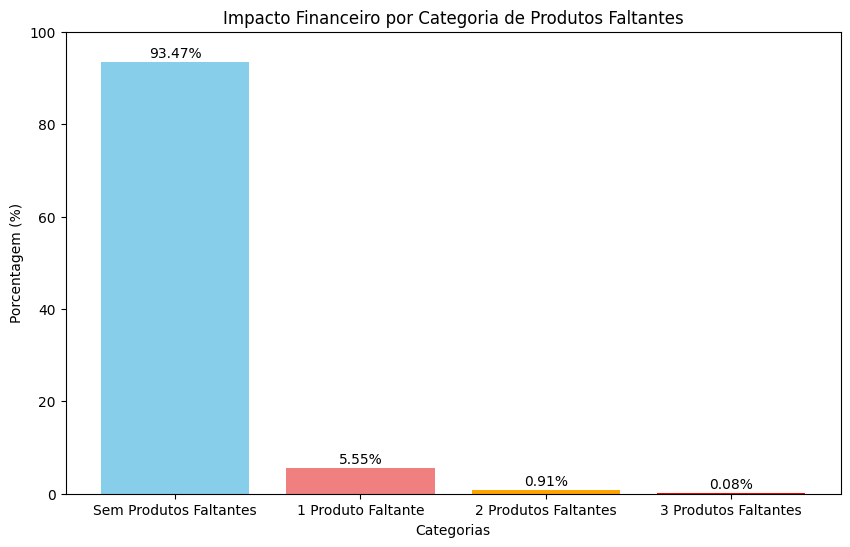

In [47]:
# Dados para o gráfico
categories = ['Sem Produtos Faltantes', '1 Produto Faltante', '2 Produtos Faltantes', '3 Produtos Faltantes']
values = [percentual_normais, percentual_1_item, percentual_2_itens, percentual_3_itens]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'lightcoral', 'orange', 'red'])
plt.title("Impacto Financeiro por Categoria de Produtos Faltantes")
plt.ylabel("Porcentagem (%)")
plt.xlabel("Categorias")
plt.ylim(0, 100)  # Limitar o eixo Y para facilitar a visualização das proporções

# Adicionar rótulos nas barras
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=10)

plt.show()

* **Pedidos Completos:** A maioria dos pedidos foi entregue sem produtos faltantes, resultando em um valor total significativo de vendas. Isso indica uma alta eficiência nos processos de entrega.

* **Pedidos com Produtos Faltantes:** Foi identificado um número considerável de pedidos com produtos faltantes, resultando em perdas financeiras. Essas perdas foram agrupadas com base no número de produtos faltantes (1, 2 ou 3 produtos), e o valor total perdido foi calculado para cada grupo.

### Análise de Prejuízo com Itens Faltantes
* Calcular o prejuízo total devido a produtos faltantes em pedidos
* Analisar proporções de vendas normais versus problemáticas

In [48]:
#prejuizo total com itens faltantes
valor_total_produtos_faltantes = valor_total_1_item + valor_total_2_itens + valor_total_3_itens

# Calcular o valor total de vendas (normais + problemáticas)
valor_total_vendas = valor_total_normais + valor_total_produtos_faltantes

# Calcular as proporções em porcentagem
percentual_produtos_faltantes = (valor_total_produtos_faltantes / valor_total_vendas) * 100
percentual_vendas_normais = (valor_total_normais / valor_total_vendas) * 100

# Exibir as proporções calculadas
print(f"Valor total de vendas sem produtos faltantes: ${valor_total_normais:.2f}")
print(f"Porcentagem de vendas normais: {percentual_vendas_normais:.2f}%")
print()
print(f"Valor total de dos produtos faltantes: ${valor_total_produtos_faltantes:.2f}")
print(f"Porcentagem de prejuízo com itens faltantes: {percentual_produtos_faltantes:.2f}%")


Valor total de vendas sem produtos faltantes: $2316265.00
Porcentagem de vendas normais: 93.47%

Valor total de dos produtos faltantes: $161934.29
Porcentagem de prejuízo com itens faltantes: 6.53%


### Visualizar Prejuízo com Itens Faltantes

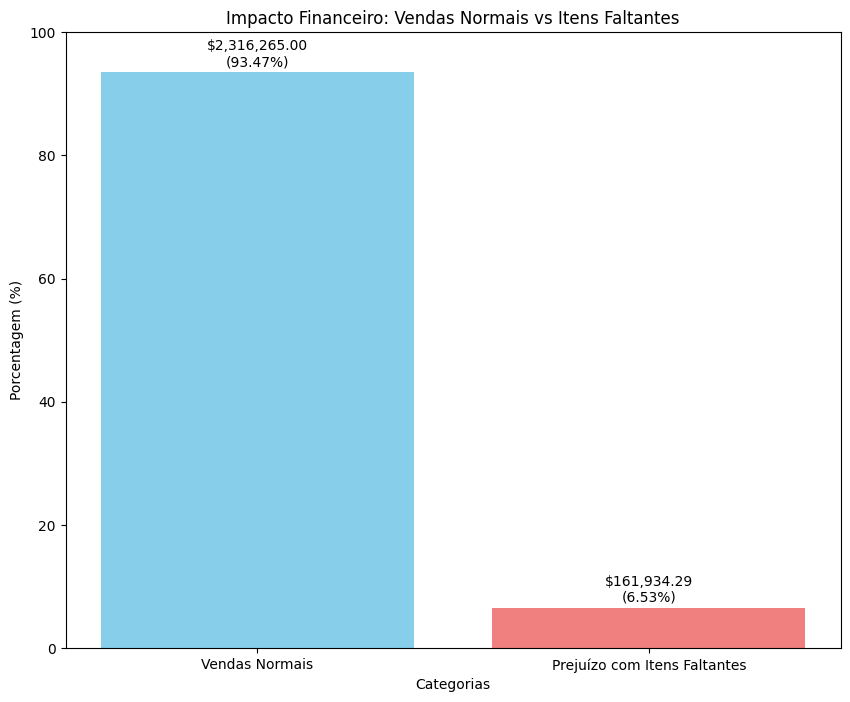

In [49]:
# Dados para o gráfico
categories = ['Vendas Normais', 'Prejuízo com Itens Faltantes']
values = [percentual_vendas_normais, percentual_produtos_faltantes]
absolute_values = [valor_total_normais, valor_total_produtos_faltantes]

# Criar o gráfico de barras
plt.figure(figsize=(10, 8))
bars = plt.bar(categories, values, color=['skyblue', 'lightcoral'])
plt.title("Impacto Financeiro: Vendas Normais vs Itens Faltantes")
plt.ylabel("Porcentagem (%)")
plt.xlabel("Categorias")
plt.ylim(0, 100)  # Limitar o eixo Y para facilitar a visualização das proporções

# Adicionar rótulos nas barras (valores absolutos e porcentagens)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"${absolute_values[i]:,.2f}\n({values[i]:.2f}%)",
             ha='center', fontsize=10)

plt.show()


* A maioria das vendas são realizadas sem produtos faltantes, o que é um bom indicador da eficiência do sistema de logística e entrega. A alta porcentagem de vendas normais demonstra que a maior parte dos pedidos são completados com sucesso, garantindo a satisfação do cliente.
* Apesar da alta eficiência, há uma porcentagem de 6.53% das vendas que resultam em prejuízo devido a produtos faltantes. Este número pode parecer pequeno, mas representa uma perda significativa de $161,934.29. Isso indica a necessidade de identificar e abordar as causas dos itens faltantes para minimizar essas perdas.

## Relatorio das Análises Cruzadas
A integração dos datasets analisados previamente para criar um dataset consolidado (`df_final`) que permitiu análises cruzadas mais detalhadas. As análises cobriram motoristas, clientes, produtos, regiões, horários críticos e o impacto financeiro de itens faltantes.

### Insights Obtidos
#### Motoristas
1. Altas Taxas de Reclamações:
   * Motoristas como Timothy Brown (8 itens perdidos) e Brittany Gordon (6 itens perdidos) foram identificados como problemáticos.
2.	Padrões Consistentes:
    * Um grupo de 10 motoristas apresentou exatamente 54,5% de itens perdidos em suas entregas, sugerindo problemas operacionais ou comportamento suspeito.
3.	Faixa Etária:
    * Motoristas mais velhos (56–65 anos) tiveram a maior taxa média de itens perdidos (0,1849), enquanto motoristas jovens (18–25 anos) apresentaram a menor taxa (0,1487).
#### Clientes
1.	**Clientes Problemáticos:**
    * Clientes como Cory Spencer e Crystal Smith reportaram 100% de itens faltantes em seus pedidos.
2.	**Faixa Etária:**
    * O grupo 36–45 anos teve a maior taxa média de itens faltantes (0,1757), enquanto 18–25 anos teve a menor (0,1635).
3.	**Impacto Financeiro:**
    * Clientes reincidentes representam um risco financeiro significativo devido à reposição frequente de produtos.
#### Produtos
1.	**Categorias Críticas:**
    * A categoria “Supermarket” foi a mais reportada como faltante.
2.	**Produtos Específicos:**
    * Itens como “Ground Coffee” e “Chicken Breast” foram consistentemente reportados como faltantes.
3.	**Co-ocorrência Limitada:**
    * Não houve padrões fortes de co-ocorrência entre produtos faltantes.
#### Regiões e Horários Críticos
1.	**Períodos Críticos:**
    * A manhã apresentou a maior taxa média de reclamações (`0,177`), seguida pela noite (`0,162`).
2.	**Regiões Problemáticas:**
    * Apopka apresentou altas taxas médias em todos os períodos do dia, com destaque para a noite (`0,189`).
3.	**Dias da Semana:**
    * Segunda-feira teve a maior taxa média de reclamações (`0,178`), enquanto quinta-feira teve a menor (`0,151`).
#### Impacto Financeiro
1.	**Eficiência Geral:**
    * 93,47% das vendas foram realizadas sem problemas.
2.	**Prejuízo com Itens Faltantes:**
    * O prejuízo financeiro total foi de $161.934,29 (6,53% das vendas totais).
3.	**Produtos Críticos:**
    * Pedidos com apenas 1 produto faltante representaram a maior parte do impacto financeiro ($137.480,26).
#### Resultados e Conclusões
1.	**Motoristas Problemáticos:**
    * Motoristas como Timothy Brown e Brittany Gordon são prioritários para investigação devido às suas altas taxas médias de itens perdidos.
2.	**Clientes Reincidentes:**
    * Clientes como Cory Spencer representam um risco financeiro significativo e devem ser monitorados.
3.	**Produtos Críticos:**
    * A categoria “Supermarket” e produtos específicos como “Ground Coffee” requerem atenção especial para reduzir perdas.
4.	**Regiões e Períodos Críticos:**
    * Apopka e entregas feitas pela manhã são pontos críticos que exigem melhorias operacionais.
5.	**Impacto Financeiro Significativo:**
    * Apesar da alta eficiência geral (93,47%), o prejuízo financeiro causado por itens faltantes é significativo e justifica ações corretivas.

### Recomendações de Medidas Preventivas
1.	**Motoristas e Operações Logísticas:**
    * Realizar auditorias direcionadas nos motoristas problemáticos para identificar possíveis desvios ou falhas operacionais.
    * Oferecer treinamento adicional para motoristas jovens (18–25 anos) e monitorar motoristas mais velhos (56–65 anos) com maiores taxas médias.
2.	**Clientes Reincidentes:**
    * Monitorar clientes com altas taxas médias de reclamações para identificar possíveis fraudes ou problemas logísticos recorrentes.
3.	**Produtos Críticos:**
    * Revisar os processos logísticos associados aos produtos mais frequentemente reportados como faltantes para identificar gargalos ou falhas específicas.
4.	**Regiões Problemáticas e Períodos Críticos:**
    * Implementar melhorias operacionais em regiões críticas como Apopka e reforçar os processos logísticos para entregas feitas pela manhã.
5.	**Rastreamento Avançado e Controle Operacional:**
    * Adotar tecnologias avançadas (ex.: QR codes ou RFID) para rastrear produtos ao longo da cadeia logística.
    * Garantir verificações adicionais em pedidos contendo múltiplos itens caros ou categorias críticas.
6.	**Redução do Impacto Financeiro:**
    * Estabelecer metas claras para reduzir o prejuízo percentual associado a itens faltantes (ex.: diminuir de 6,53% para 4% em um ano).

In [50]:
df_final.to_csv('df_final.csv', index=False)